In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


2023-12-18 15:50:33.152708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
#from u_interpolate_small import regrid_irregular_quick
from datetime import date
import u_interpolate_small as uint
from ndays import numOfDays
import glob
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cf
import pickle 
import calendar

In [3]:
# Define domain and time period
start_lat = 12 # 5 
end_lat = 17 #10
start_lon = -17 #-10
end_lon = -12 #0
start_year = '2010'
start_month = '06'
end_year = '2012'
end_month = '09'
start_day = '01'
end_day = '30'

# find ndays
date1 = date(int(start_year), int(start_month), int(start_day))
date2 = date(int(start_year), int(end_month), int(end_day))
t = (int(end_year)-int(start_year)+1)*(numOfDays(date1, date2)+1)

# define a regular lat/lon grid close to MSG native resolution (0.04 deg)
#reg_lat = np.arange(start_lat, end_lat, 0.04)
#reg_lon = np.arange(start_lon, end_lon, 0.04) 

In [4]:
# get native MSG grid (core)
coords_filename= './nxny1640_580_nxnyds164580_blobdx0.04491576_area4_n23_20_32.nc'#[0]  # this is /prj/Africa_cloud/geoloc/*.npz on the Linux system
msg_file = xr.open_dataset(coords_filename).squeeze() # pick any convective core file from ch9_wavelet. 
mlon = msg_file['lons_mid'].values
mlat = msg_file['lats_mid'].values


In [5]:
# find core indices using one file
lat_ind = np.where((mlat[:,1]>=start_lat) & (mlat[:,1]<=end_lat))[0]
lon_ind = np.where((mlon[1,:]>=start_lon) & (mlon[1,:]<=end_lon))[0]
lat = mlat[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
lon = mlon[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
#lon = lon_fl[(lon_fl>= start_lon) & (lon_fl<=end_lon)]
#X, Y = np.meshgrid(lon,lat)


#### change t multiplicative factor based on hourly vs 15min data
cores = np.zeros((t*24,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
tir = np.zeros((t*24,len(lat[:,1]),len(lon[1,:])),dtype=float) #using every fourth value for hourly comparison- 24hr
time_core = np.zeros((t*24)) #using every fourth value for hourly comparison- 24hr

In [6]:
# read in cores data
list_of_file_names = []

if int(start_year)==int(end_year): 
    for m in range(int(start_month),int(end_month)+1,1): # 1 to include the end month
        if m<10:
            month = str(m).zfill(2)
        else:
            month = str(m)  
        for d in range(1,calendar.monthrange(int(start_year), m)[1]+1,1): # 1 to include the end month
            if d<10:
                day = str(d).zfill(2)
            else:
                day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
            dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*00.nc"));
            list_of_file_names.append(all_file_names) # all days in month
        #if os.path.isfile(all_file_names):      
         #   list_of_file_names.append(all_file_names) # all days in month
        #else:
         #   list_of_file_names.append('file_not_available') # all days in month
            #print(all_file_names)
elif int(start_year)<int(end_year):
   # y=1
    for i in range(int(start_year),int(end_year)+1,1):
       # if y==1:
            for m in range(int(start_month),int(end_month)+1,1):
                if m<10:
                    month = str(m).zfill(2)
                else:
                    month = str(m)  
                for d in range(1,calendar.monthrange(i, m)[1]+1,1):
                #for d in range(1,30,1): # 1 to include the end month
                    if d<10:
                        day = str(d).zfill(2)
                    else:
                        day = str(d)  
            #core_filename= '/prj/nflics/hist_cores/2008/06/01/Hist_cores_wa_200806011045.nc'
                    dir_name = '/prj/nflics/hist_cores/'+str(i)+'/'+month+'/'+day+'/'
                    all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*00.nc"));
                    list_of_file_names.append(all_file_names) # all days in month
            #print((all_file_names))
                #print(len(all_file_names))
             #   y=y+1
                month=[]
            
      #  else:
        #    for m in range(1,int(end_month)+1,1):
        #        if m<10:
         #           month = str(m).zfill(2)
        #        else:
        #            month = str(m)    
        #        for d in range(1,calendar.monthrange(i, m)[1]+1,1):
        #            if d<10:
        #                day = str(d).zfill(2)
         #           else:
         #               day = str(d)  
         #           dir_name = '/prj/nflics/hist_cores/'+start_year+'/'+month+'/'+day+'/'
        #            all_file_names=sorted(glob.glob(dir_name+"Hist_cores_wa_*00.nc"));
         #           list_of_file_names.append(all_file_names) # all days in month
                  
list_of_files=[]                
for a in range(0,len(list_of_file_names),1):
    list_of_files = list_of_files+list_of_file_names[a]
#if int(start_year)<int(end_year):
 #   list_of_files = list_of_files[0]+list_of_files[1]
#else:
   # list_of_files = list_of_files[0]#+list_of_files[1]    
print(len(list_of_files))

8778


In [7]:
for l in range(0,len(list_of_files),1):#, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_files[l]#'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    #if os.path.isfile(all_file_names):      
    ds = xr.open_dataset(core_filename).squeeze() 
    print(l)
    core_temp = ds['msg_cores'].values
    cores[l,:,:] = core_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
    #uint.interpolate_data(ds['cores'].values, inds, weights, shape) # interpolation using saved weights for MSG cores       
    tir_temp =  ds['msg_Tir'].values/10000
    tir[l,:,:] = tir_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]    
    time_core[l] = str(core_filename[-15:-3])
    #else:
     #   cores[:,:,l] = cores_temp*np.nan  
      #  tir[:,:,l] = tir_temp*np.nan   
       # time_core[l] = (core_filename[-15:-3])
  

/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010000.nc
0
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010100.nc
1
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010200.nc
2
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010300.nc
3
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010400.nc
4
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010500.nc
5
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010600.nc
6
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010700.nc
7
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010800.nc
8
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006010900.nc
9
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011000.nc
10
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011100.nc
11
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011200.nc
12
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011300.nc
13
/prj/nflics/hist_cores/2010/06/01/Hist_cores_wa_201006011400.nc
14
/prj/

/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060400.nc
124
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060500.nc
125
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060600.nc
126
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060700.nc
127
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060800.nc
128
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006060900.nc
129
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061000.nc
130
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061100.nc
131
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061200.nc
132
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061300.nc
133
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061400.nc
134
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061500.nc
135
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061600.nc
136
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_201006061700.nc
137
/prj/nflics/hist_cores/2010/06/06/Hist_cores_wa_

245
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110600.nc
246
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110700.nc
247
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110800.nc
248
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006110900.nc
249
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111000.nc
250
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111100.nc
251
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111200.nc
252
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111300.nc
253
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111400.nc
254
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111500.nc
255
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111600.nc
256
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111700.nc
257
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111800.nc
258
/prj/nflics/hist_cores/2010/06/11/Hist_cores_wa_201006111900.nc
259
/prj/nflics/hist_cores/2010/06/11/Hist_cores

/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160800.nc
368
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006160900.nc
369
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161000.nc
370
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161100.nc
371
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161200.nc
372
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161300.nc
373
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161400.nc
374
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161500.nc
375
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161600.nc
376
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161700.nc
377
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161800.nc
378
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006161900.nc
379
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006162000.nc
380
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_201006162100.nc
381
/prj/nflics/hist_cores/2010/06/16/Hist_cores_wa_

489
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211000.nc
490
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211100.nc
491
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211200.nc
492
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211300.nc
493
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211400.nc
494
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211500.nc
495
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211600.nc
496
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211700.nc
497
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211800.nc
498
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006211900.nc
499
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006212000.nc
500
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006212100.nc
501
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006212200.nc
502
/prj/nflics/hist_cores/2010/06/21/Hist_cores_wa_201006212300.nc
503
/prj/nflics/hist_cores/2010/06/22/Hist_cores

612
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261300.nc
613
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261400.nc
614
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261500.nc
615
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261600.nc
616
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261700.nc
617
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261800.nc
618
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006261900.nc
619
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262000.nc
620
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262100.nc
621
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262200.nc
622
/prj/nflics/hist_cores/2010/06/26/Hist_cores_wa_201006262300.nc
623
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270000.nc
624
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270100.nc
625
/prj/nflics/hist_cores/2010/06/27/Hist_cores_wa_201006270200.nc
626
/prj/nflics/hist_cores/2010/06/27/Hist_cores

734
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011500.nc
735
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011600.nc
736
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011700.nc
737
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011800.nc
738
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007011900.nc
739
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012000.nc
740
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012100.nc
741
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012200.nc
742
/prj/nflics/hist_cores/2010/07/01/Hist_cores_wa_201007012300.nc
743
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020000.nc
744
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020100.nc
745
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020200.nc
746
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020300.nc
747
/prj/nflics/hist_cores/2010/07/02/Hist_cores_wa_201007020400.nc
748
/prj/nflics/hist_cores/2010/07/02/Hist_cores

856
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061700.nc
857
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061800.nc
858
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007061900.nc
859
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062000.nc
860
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062100.nc
861
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062200.nc
862
/prj/nflics/hist_cores/2010/07/06/Hist_cores_wa_201007062300.nc
863
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070000.nc
864
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070100.nc
865
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070200.nc
866
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070300.nc
867
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070400.nc
868
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070500.nc
869
/prj/nflics/hist_cores/2010/07/07/Hist_cores_wa_201007070600.nc
870
/prj/nflics/hist_cores/2010/07/07/Hist_cores

977
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111800.nc
978
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007111900.nc
979
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112000.nc
980
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112100.nc
981
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112200.nc
982
/prj/nflics/hist_cores/2010/07/11/Hist_cores_wa_201007112300.nc
983
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120000.nc
984
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120100.nc
985
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120200.nc
986
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120300.nc
987
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120400.nc
988
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120500.nc
989
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120600.nc
990
/prj/nflics/hist_cores/2010/07/12/Hist_cores_wa_201007120700.nc
991
/prj/nflics/hist_cores/2010/07/12/Hist_cores

1098
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007161900.nc
1099
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162000.nc
1100
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162100.nc
1101
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162200.nc
1102
/prj/nflics/hist_cores/2010/07/16/Hist_cores_wa_201007162300.nc
1103
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170000.nc
1104
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170100.nc
1105
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170200.nc
1106
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170300.nc
1107
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170400.nc
1108
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170500.nc
1109
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170600.nc
1110
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170700.nc
1111
/prj/nflics/hist_cores/2010/07/17/Hist_cores_wa_201007170800.nc
1112
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211800.nc
1218
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007211900.nc
1219
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212000.nc
1220
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212100.nc
1221
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212200.nc
1222
/prj/nflics/hist_cores/2010/07/21/Hist_cores_wa_201007212300.nc
1223
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220000.nc
1224
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220100.nc
1225
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220200.nc
1226
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220300.nc
1227
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220400.nc
1228
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220500.nc
1229
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220600.nc
1230
/prj/nflics/hist_cores/2010/07/22/Hist_cores_wa_201007220700.nc
1231
/prj/nflics/hist_cores/2010/07/22/

1336
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261700.nc
1337
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261800.nc
1338
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007261900.nc
1339
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262000.nc
1340
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262100.nc
1341
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262200.nc
1342
/prj/nflics/hist_cores/2010/07/26/Hist_cores_wa_201007262300.nc
1343
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270000.nc
1344
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270100.nc
1345
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270200.nc
1346
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270300.nc
1347
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270400.nc
1348
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270500.nc
1349
/prj/nflics/hist_cores/2010/07/27/Hist_cores_wa_201007270600.nc
1350
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311600.nc
1456
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311700.nc
1457
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311800.nc
1458
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007311900.nc
1459
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312000.nc
1460
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312100.nc
1461
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312200.nc
1462
/prj/nflics/hist_cores/2010/07/31/Hist_cores_wa_201007312300.nc
1463
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010000.nc
1464
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010100.nc
1465
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010200.nc
1466
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010300.nc
1467
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010400.nc
1468
/prj/nflics/hist_cores/2010/08/01/Hist_cores_wa_201008010500.nc
1469
/prj/nflics/hist_cores/2010/08/01/

1575
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051600.nc
1576
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051700.nc
1577
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051800.nc
1578
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008051900.nc
1579
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052000.nc
1580
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052100.nc
1581
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052200.nc
1582
/prj/nflics/hist_cores/2010/08/05/Hist_cores_wa_201008052300.nc
1583
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060000.nc
1584
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060100.nc
1585
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060200.nc
1586
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060300.nc
1587
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060400.nc
1588
/prj/nflics/hist_cores/2010/08/06/Hist_cores_wa_201008060500.nc
1589
/prj/nflics/hist_cores/2010/0

1694
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101500.nc
1695
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101600.nc
1696
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101700.nc
1697
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101800.nc
1698
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008101900.nc
1699
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102000.nc
1700
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102100.nc
1701
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102200.nc
1702
/prj/nflics/hist_cores/2010/08/10/Hist_cores_wa_201008102300.nc
1703
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110000.nc
1704
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110100.nc
1705
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110200.nc
1706
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110300.nc
1707
/prj/nflics/hist_cores/2010/08/11/Hist_cores_wa_201008110400.nc
1708
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151500.nc
1815
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151600.nc
1816
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151700.nc
1817
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151800.nc
1818
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008151900.nc
1819
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152000.nc
1820
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152100.nc
1821
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152200.nc
1822
/prj/nflics/hist_cores/2010/08/15/Hist_cores_wa_201008152300.nc
1823
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160000.nc
1824
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160100.nc
1825
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160200.nc
1826
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160300.nc
1827
/prj/nflics/hist_cores/2010/08/16/Hist_cores_wa_201008160400.nc
1828
/prj/nflics/hist_cores/2010/08/16/

1933
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201400.nc
1934
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201500.nc
1935
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201600.nc
1936
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201700.nc
1937
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201800.nc
1938
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008201900.nc
1939
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202000.nc
1940
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202100.nc
1941
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202200.nc
1942
/prj/nflics/hist_cores/2010/08/20/Hist_cores_wa_201008202300.nc
1943
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210000.nc
1944
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210100.nc
1945
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210200.nc
1946
/prj/nflics/hist_cores/2010/08/21/Hist_cores_wa_201008210300.nc
1947
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251400.nc
2054
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251500.nc
2055
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251600.nc
2056
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251700.nc
2057
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251800.nc
2058
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008251900.nc
2059
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252000.nc
2060
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252100.nc
2061
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252200.nc
2062
/prj/nflics/hist_cores/2010/08/25/Hist_cores_wa_201008252300.nc
2063
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260000.nc
2064
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260100.nc
2065
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260200.nc
2066
/prj/nflics/hist_cores/2010/08/26/Hist_cores_wa_201008260300.nc
2067
/prj/nflics/hist_cores/2010/08/26/

2173
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301400.nc
2174
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301500.nc
2175
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301600.nc
2176
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301700.nc
2177
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301800.nc
2178
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008301900.nc
2179
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302000.nc
2180
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302100.nc
2181
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302200.nc
2182
/prj/nflics/hist_cores/2010/08/30/Hist_cores_wa_201008302300.nc
2183
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310000.nc
2184
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310100.nc
2185
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310200.nc
2186
/prj/nflics/hist_cores/2010/08/31/Hist_cores_wa_201008310300.nc
2187
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041400.nc
2294
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041500.nc
2295
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041600.nc
2296
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041700.nc
2297
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041800.nc
2298
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009041900.nc
2299
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009042000.nc
2300
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009042100.nc
2301
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009042200.nc
2302
/prj/nflics/hist_cores/2010/09/04/Hist_cores_wa_201009042300.nc
2303
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050000.nc
2304
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050100.nc
2305
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050200.nc
2306
/prj/nflics/hist_cores/2010/09/05/Hist_cores_wa_201009050300.nc
2307
/prj/nflics/hist_cores/2010/09/05/

2413
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091400.nc
2414
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091500.nc
2415
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091600.nc
2416
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091700.nc
2417
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091800.nc
2418
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009091900.nc
2419
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009092000.nc
2420
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009092100.nc
2421
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009092200.nc
2422
/prj/nflics/hist_cores/2010/09/09/Hist_cores_wa_201009092300.nc
2423
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100000.nc
2424
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100100.nc
2425
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100200.nc
2426
/prj/nflics/hist_cores/2010/09/10/Hist_cores_wa_201009100300.nc
2427
/prj/nflics/hist_cores/2010/0

2534
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141500.nc
2535
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141600.nc
2536
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141700.nc
2537
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141800.nc
2538
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009141900.nc
2539
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009142000.nc
2540
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009142100.nc
2541
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009142200.nc
2542
/prj/nflics/hist_cores/2010/09/14/Hist_cores_wa_201009142300.nc
2543
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150000.nc
2544
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150100.nc
2545
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150200.nc
2546
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150300.nc
2547
/prj/nflics/hist_cores/2010/09/15/Hist_cores_wa_201009150400.nc
2548
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191500.nc
2655
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191600.nc
2656
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191700.nc
2657
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191800.nc
2658
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009191900.nc
2659
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192000.nc
2660
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192100.nc
2661
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192200.nc
2662
/prj/nflics/hist_cores/2010/09/19/Hist_cores_wa_201009192300.nc
2663
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200000.nc
2664
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200100.nc
2665
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200200.nc
2666
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200300.nc
2667
/prj/nflics/hist_cores/2010/09/20/Hist_cores_wa_201009200400.nc
2668
/prj/nflics/hist_cores/2010/09/20/

2775
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241600.nc
2776
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241700.nc
2777
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241800.nc
2778
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009241900.nc
2779
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242000.nc
2780
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242100.nc
2781
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242200.nc
2782
/prj/nflics/hist_cores/2010/09/24/Hist_cores_wa_201009242300.nc
2783
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250000.nc
2784
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250100.nc
2785
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250200.nc
2786
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250300.nc
2787
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250400.nc
2788
/prj/nflics/hist_cores/2010/09/25/Hist_cores_wa_201009250500.nc
2789
/prj/nflics/hist_cores/2010/0

/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291600.nc
2896
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291700.nc
2897
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291800.nc
2898
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009291900.nc
2899
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292000.nc
2900
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292100.nc
2901
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292200.nc
2902
/prj/nflics/hist_cores/2010/09/29/Hist_cores_wa_201009292300.nc
2903
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300000.nc
2904
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300100.nc
2905
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300200.nc
2906
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300300.nc
2907
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300400.nc
2908
/prj/nflics/hist_cores/2010/09/30/Hist_cores_wa_201009300500.nc
2909
/prj/nflics/hist_cores/2010/09/30/

3016
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041700.nc
3017
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041800.nc
3018
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106041900.nc
3019
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042000.nc
3020
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042100.nc
3021
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042200.nc
3022
/prj/nflics/hist_cores/2011/06/04/Hist_cores_wa_201106042300.nc
3023
/prj/nflics/hist_cores/2011/06/05/Hist_cores_wa_201106050000.nc
3024
/prj/nflics/hist_cores/2011/06/05/Hist_cores_wa_201106050100.nc
3025
/prj/nflics/hist_cores/2011/06/05/Hist_cores_wa_201106050200.nc
3026
/prj/nflics/hist_cores/2011/06/05/Hist_cores_wa_201106050300.nc
3027
/prj/nflics/hist_cores/2011/06/05/Hist_cores_wa_201106050400.nc
3028
/prj/nflics/hist_cores/2011/06/05/Hist_cores_wa_201106050500.nc
3029
/prj/nflics/hist_cores/2011/06/05/Hist_cores_wa_201106050600.nc
3030
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091600.nc
3136
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091700.nc
3137
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091800.nc
3138
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106091900.nc
3139
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092000.nc
3140
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092100.nc
3141
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092200.nc
3142
/prj/nflics/hist_cores/2011/06/09/Hist_cores_wa_201106092300.nc
3143
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100000.nc
3144
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100100.nc
3145
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100200.nc
3146
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100300.nc
3147
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100400.nc
3148
/prj/nflics/hist_cores/2011/06/10/Hist_cores_wa_201106100500.nc
3149
/prj/nflics/hist_cores/2011/06/10/

3254
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141500.nc
3255
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141600.nc
3256
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141700.nc
3257
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141800.nc
3258
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106141900.nc
3259
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142000.nc
3260
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142100.nc
3261
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142200.nc
3262
/prj/nflics/hist_cores/2011/06/14/Hist_cores_wa_201106142300.nc
3263
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150000.nc
3264
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150100.nc
3265
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150200.nc
3266
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150300.nc
3267
/prj/nflics/hist_cores/2011/06/15/Hist_cores_wa_201106150400.nc
3268
/prj/nflics/hist_cores/2011/0

3375
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191600.nc
3376
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191700.nc
3377
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191800.nc
3378
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106191900.nc
3379
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192000.nc
3380
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192100.nc
3381
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192200.nc
3382
/prj/nflics/hist_cores/2011/06/19/Hist_cores_wa_201106192300.nc
3383
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200000.nc
3384
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200100.nc
3385
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200200.nc
3386
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200300.nc
3387
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200400.nc
3388
/prj/nflics/hist_cores/2011/06/20/Hist_cores_wa_201106200500.nc
3389
/prj/nflics/hist_cores/2011/0

3495
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241600.nc
3496
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241700.nc
3497
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241800.nc
3498
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106241900.nc
3499
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242000.nc
3500
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242100.nc
3501
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242200.nc
3502
/prj/nflics/hist_cores/2011/06/24/Hist_cores_wa_201106242300.nc
3503
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250000.nc
3504
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250100.nc
3505
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250200.nc
3506
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250300.nc
3507
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250400.nc
3508
/prj/nflics/hist_cores/2011/06/25/Hist_cores_wa_201106250500.nc
3509
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291600.nc
3616
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291700.nc
3617
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291800.nc
3618
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106291900.nc
3619
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292000.nc
3620
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292100.nc
3621
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292200.nc
3622
/prj/nflics/hist_cores/2011/06/29/Hist_cores_wa_201106292300.nc
3623
/prj/nflics/hist_cores/2011/06/30/Hist_cores_wa_201106300000.nc
3624
/prj/nflics/hist_cores/2011/06/30/Hist_cores_wa_201106300100.nc
3625
/prj/nflics/hist_cores/2011/06/30/Hist_cores_wa_201106300200.nc
3626
/prj/nflics/hist_cores/2011/06/30/Hist_cores_wa_201106300300.nc
3627
/prj/nflics/hist_cores/2011/06/30/Hist_cores_wa_201106300400.nc
3628
/prj/nflics/hist_cores/2011/06/30/Hist_cores_wa_201106300500.nc
3629
/prj/nflics/hist_cores/2011/06/30/

3734
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041500.nc
3735
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041600.nc
3736
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041700.nc
3737
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041800.nc
3738
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107041900.nc
3739
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042000.nc
3740
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042100.nc
3741
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042200.nc
3742
/prj/nflics/hist_cores/2011/07/04/Hist_cores_wa_201107042300.nc
3743
/prj/nflics/hist_cores/2011/07/05/Hist_cores_wa_201107050000.nc
3744
/prj/nflics/hist_cores/2011/07/05/Hist_cores_wa_201107050100.nc
3745
/prj/nflics/hist_cores/2011/07/05/Hist_cores_wa_201107050200.nc
3746
/prj/nflics/hist_cores/2011/07/05/Hist_cores_wa_201107050300.nc
3747
/prj/nflics/hist_cores/2011/07/05/Hist_cores_wa_201107050400.nc
3748
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091400.nc
3854
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091500.nc
3855
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091600.nc
3856
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091700.nc
3857
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091800.nc
3858
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107091900.nc
3859
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092000.nc
3860
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092100.nc
3861
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092200.nc
3862
/prj/nflics/hist_cores/2011/07/09/Hist_cores_wa_201107092300.nc
3863
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100000.nc
3864
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100100.nc
3865
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100200.nc
3866
/prj/nflics/hist_cores/2011/07/10/Hist_cores_wa_201107100300.nc
3867
/prj/nflics/hist_cores/2011/07/10/

/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141300.nc
3973
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141400.nc
3974
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141500.nc
3975
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141600.nc
3976
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141700.nc
3977
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141800.nc
3978
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107141900.nc
3979
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142000.nc
3980
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142100.nc
3981
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142200.nc
3982
/prj/nflics/hist_cores/2011/07/14/Hist_cores_wa_201107142300.nc
3983
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107150000.nc
3984
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107150100.nc
3985
/prj/nflics/hist_cores/2011/07/15/Hist_cores_wa_201107150200.nc
3986
/prj/nflics/hist_cores/2011/07/15/

4092
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191300.nc
4093
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191400.nc
4094
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191500.nc
4095
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191600.nc
4096
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191700.nc
4097
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191800.nc
4098
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107191900.nc
4099
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107192000.nc
4100
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107192100.nc
4101
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107192200.nc
4102
/prj/nflics/hist_cores/2011/07/19/Hist_cores_wa_201107192300.nc
4103
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107200000.nc
4104
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107200100.nc
4105
/prj/nflics/hist_cores/2011/07/20/Hist_cores_wa_201107200200.nc
4106
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241200.nc
4212
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241300.nc
4213
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241400.nc
4214
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241500.nc
4215
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241600.nc
4216
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241700.nc
4217
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241800.nc
4218
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107241900.nc
4219
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107242000.nc
4220
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107242100.nc
4221
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107242200.nc
4222
/prj/nflics/hist_cores/2011/07/24/Hist_cores_wa_201107242300.nc
4223
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107250000.nc
4224
/prj/nflics/hist_cores/2011/07/25/Hist_cores_wa_201107250100.nc
4225
/prj/nflics/hist_cores/2011/07/25/

/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291100.nc
4331
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291200.nc
4332
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291300.nc
4333
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291400.nc
4334
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291500.nc
4335
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291600.nc
4336
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291700.nc
4337
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291800.nc
4338
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107291900.nc
4339
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107292000.nc
4340
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107292100.nc
4341
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107292200.nc
4342
/prj/nflics/hist_cores/2011/07/29/Hist_cores_wa_201107292300.nc
4343
/prj/nflics/hist_cores/2011/07/30/Hist_cores_wa_201107300000.nc
4344
/prj/nflics/hist_cores/2011/07/30/

/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031000.nc
4450
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031100.nc
4451
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031200.nc
4452
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031300.nc
4453
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031400.nc
4454
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031500.nc
4455
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031600.nc
4456
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031700.nc
4457
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031800.nc
4458
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108031900.nc
4459
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108032000.nc
4460
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108032100.nc
4461
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108032200.nc
4462
/prj/nflics/hist_cores/2011/08/03/Hist_cores_wa_201108032300.nc
4463
/prj/nflics/hist_cores/2011/08/04/

4570
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081100.nc
4571
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081200.nc
4572
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081300.nc
4573
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081400.nc
4574
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081500.nc
4575
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081600.nc
4576
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081700.nc
4577
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081800.nc
4578
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108081900.nc
4579
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108082000.nc
4580
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108082100.nc
4581
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108082200.nc
4582
/prj/nflics/hist_cores/2011/08/08/Hist_cores_wa_201108082300.nc
4583
/prj/nflics/hist_cores/2011/08/09/Hist_cores_wa_201108090000.nc
4584
/prj/nflics/hist_cores/2011/0

4689
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131000.nc
4690
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131100.nc
4691
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131200.nc
4692
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131300.nc
4693
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131400.nc
4694
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131500.nc
4695
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131600.nc
4696
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131700.nc
4697
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131800.nc
4698
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108131900.nc
4699
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108132000.nc
4700
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108132100.nc
4701
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108132200.nc
4702
/prj/nflics/hist_cores/2011/08/13/Hist_cores_wa_201108132300.nc
4703
/prj/nflics/hist_cores/2011/0

4808
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108180900.nc
4809
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181000.nc
4810
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181100.nc
4811
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181200.nc
4812
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181300.nc
4813
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181400.nc
4814
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181500.nc
4815
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181600.nc
4816
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181700.nc
4817
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181800.nc
4818
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108181900.nc
4819
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108182000.nc
4820
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108182100.nc
4821
/prj/nflics/hist_cores/2011/08/18/Hist_cores_wa_201108182200.nc
4822
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108230900.nc
4929
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231000.nc
4930
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231100.nc
4931
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231200.nc
4932
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231300.nc
4933
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231400.nc
4934
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231500.nc
4935
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231600.nc
4936
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231700.nc
4937
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231800.nc
4938
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108231900.nc
4939
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108232000.nc
4940
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108232100.nc
4941
/prj/nflics/hist_cores/2011/08/23/Hist_cores_wa_201108232200.nc
4942
/prj/nflics/hist_cores/2011/08/23/

/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108280900.nc
5049
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281000.nc
5050
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281100.nc
5051
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281200.nc
5052
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281300.nc
5053
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281400.nc
5054
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281500.nc
5055
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281600.nc
5056
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281700.nc
5057
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281800.nc
5058
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108281900.nc
5059
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108282000.nc
5060
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108282100.nc
5061
/prj/nflics/hist_cores/2011/08/28/Hist_cores_wa_201108282200.nc
5062
/prj/nflics/hist_cores/2011/08/28/

/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020800.nc
5168
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109020900.nc
5169
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021000.nc
5170
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021100.nc
5171
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021200.nc
5172
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021300.nc
5173
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021400.nc
5174
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021500.nc
5175
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021600.nc
5176
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021700.nc
5177
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021800.nc
5178
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109021900.nc
5179
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109022000.nc
5180
/prj/nflics/hist_cores/2011/09/02/Hist_cores_wa_201109022100.nc
5181
/prj/nflics/hist_cores/2011/09/02/

/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070800.nc
5288
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109070900.nc
5289
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071000.nc
5290
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071100.nc
5291
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071200.nc
5292
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071300.nc
5293
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071400.nc
5294
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071500.nc
5295
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071600.nc
5296
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071700.nc
5297
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071800.nc
5298
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109071900.nc
5299
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109072000.nc
5300
/prj/nflics/hist_cores/2011/09/07/Hist_cores_wa_201109072100.nc
5301
/prj/nflics/hist_cores/2011/09/07/

/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120800.nc
5408
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109120900.nc
5409
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121000.nc
5410
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121100.nc
5411
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121200.nc
5412
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121300.nc
5413
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121400.nc
5414
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121500.nc
5415
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121600.nc
5416
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121700.nc
5417
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121800.nc
5418
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109121900.nc
5419
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109122000.nc
5420
/prj/nflics/hist_cores/2011/09/12/Hist_cores_wa_201109122100.nc
5421
/prj/nflics/hist_cores/2011/09/12/

5527
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170800.nc
5528
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109170900.nc
5529
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171000.nc
5530
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171100.nc
5531
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171200.nc
5532
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171300.nc
5533
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171400.nc
5534
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171500.nc
5535
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171600.nc
5536
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171700.nc
5537
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171800.nc
5538
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109171900.nc
5539
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109172000.nc
5540
/prj/nflics/hist_cores/2011/09/17/Hist_cores_wa_201109172100.nc
5541
/prj/nflics/hist_cores/2011/0

/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220800.nc
5648
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109220900.nc
5649
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221000.nc
5650
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221100.nc
5651
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221200.nc
5652
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221300.nc
5653
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221400.nc
5654
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221500.nc
5655
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221600.nc
5656
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221700.nc
5657
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221800.nc
5658
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109221900.nc
5659
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109222000.nc
5660
/prj/nflics/hist_cores/2011/09/22/Hist_cores_wa_201109222100.nc
5661
/prj/nflics/hist_cores/2011/09/22/

/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270700.nc
5767
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270800.nc
5768
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109270900.nc
5769
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271000.nc
5770
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271100.nc
5771
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271200.nc
5772
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271300.nc
5773
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271400.nc
5774
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271500.nc
5775
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271600.nc
5776
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271700.nc
5777
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271800.nc
5778
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109271900.nc
5779
/prj/nflics/hist_cores/2011/09/27/Hist_cores_wa_201109272000.nc
5780
/prj/nflics/hist_cores/2011/09/27/

5887
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020800.nc
5888
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206020900.nc
5889
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206021000.nc
5890
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206021100.nc
5891
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206021200.nc
5892
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206021300.nc
5893
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206021400.nc
5894
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206021500.nc
5895
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206021600.nc
5896
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206021700.nc
5897
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206021800.nc
5898
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206021900.nc
5899
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206022000.nc
5900
/prj/nflics/hist_cores/2012/06/02/Hist_cores_wa_201206022100.nc
5901
/prj/nflics/hist_cores/2012/0

6006
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070700.nc
6007
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070800.nc
6008
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206070900.nc
6009
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206071000.nc
6010
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206071100.nc
6011
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206071200.nc
6012
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206071300.nc
6013
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206071400.nc
6014
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206071500.nc
6015
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206071600.nc
6016
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206071700.nc
6017
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206071800.nc
6018
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206071900.nc
6019
/prj/nflics/hist_cores/2012/06/07/Hist_cores_wa_201206072000.nc
6020
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120600.nc
6126
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120700.nc
6127
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120800.nc
6128
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206120900.nc
6129
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206121000.nc
6130
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206121100.nc
6131
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206121200.nc
6132
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206121300.nc
6133
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206121400.nc
6134
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206121500.nc
6135
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206121600.nc
6136
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206121700.nc
6137
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206121800.nc
6138
/prj/nflics/hist_cores/2012/06/12/Hist_cores_wa_201206121900.nc
6139
/prj/nflics/hist_cores/2012/06/12/

6246
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170700.nc
6247
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170800.nc
6248
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206170900.nc
6249
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206171000.nc
6250
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206171100.nc
6251
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206171200.nc
6252
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206171300.nc
6253
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206171400.nc
6254
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206171500.nc
6255
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206171600.nc
6256
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206171700.nc
6257
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206171800.nc
6258
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206171900.nc
6259
/prj/nflics/hist_cores/2012/06/17/Hist_cores_wa_201206172000.nc
6260
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220600.nc
6366
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220700.nc
6367
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220800.nc
6368
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206220900.nc
6369
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206221000.nc
6370
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206221100.nc
6371
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206221200.nc
6372
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206221300.nc
6373
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206221400.nc
6374
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206221500.nc
6375
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206221600.nc
6376
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206221700.nc
6377
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206221800.nc
6378
/prj/nflics/hist_cores/2012/06/22/Hist_cores_wa_201206221900.nc
6379
/prj/nflics/hist_cores/2012/06/22/

6486
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270700.nc
6487
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270800.nc
6488
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206270900.nc
6489
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206271000.nc
6490
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206271100.nc
6491
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206271200.nc
6492
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206271300.nc
6493
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206271400.nc
6494
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206271500.nc
6495
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206271600.nc
6496
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206271700.nc
6497
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206271800.nc
6498
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206271900.nc
6499
/prj/nflics/hist_cores/2012/06/27/Hist_cores_wa_201206272000.nc
6500
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020700.nc
6607
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020800.nc
6608
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207020900.nc
6609
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207021000.nc
6610
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207021100.nc
6611
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207021200.nc
6612
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207021300.nc
6613
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207021400.nc
6614
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207021500.nc
6615
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207021600.nc
6616
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207021700.nc
6617
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207021800.nc
6618
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207021900.nc
6619
/prj/nflics/hist_cores/2012/07/02/Hist_cores_wa_201207022000.nc
6620
/prj/nflics/hist_cores/2012/07/02/

/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207071200.nc
6726
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207071300.nc
6727
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207071400.nc
6728
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207071500.nc
6729
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207071600.nc
6730
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207071700.nc
6731
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207071800.nc
6732
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207071900.nc
6733
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207072000.nc
6734
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207072100.nc
6735
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207072200.nc
6736
/prj/nflics/hist_cores/2012/07/07/Hist_cores_wa_201207072300.nc
6737
/prj/nflics/hist_cores/2012/07/08/Hist_cores_wa_201207080000.nc
6738
/prj/nflics/hist_cores/2012/07/08/Hist_cores_wa_201207080100.nc
6739
/prj/nflics/hist_cores/2012/07/08/

/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207121200.nc
6846
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207121300.nc
6847
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207121400.nc
6848
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207121500.nc
6849
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207121600.nc
6850
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207121700.nc
6851
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207121800.nc
6852
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207121900.nc
6853
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207122000.nc
6854
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207122100.nc
6855
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207122200.nc
6856
/prj/nflics/hist_cores/2012/07/12/Hist_cores_wa_201207122300.nc
6857
/prj/nflics/hist_cores/2012/07/13/Hist_cores_wa_201207130000.nc
6858
/prj/nflics/hist_cores/2012/07/13/Hist_cores_wa_201207130100.nc
6859
/prj/nflics/hist_cores/2012/07/13/

/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207171300.nc
6967
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207171400.nc
6968
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207171500.nc
6969
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207171600.nc
6970
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207171700.nc
6971
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207171800.nc
6972
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207171900.nc
6973
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207172000.nc
6974
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207172100.nc
6975
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207172200.nc
6976
/prj/nflics/hist_cores/2012/07/17/Hist_cores_wa_201207172300.nc
6977
/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207180000.nc
6978
/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207180100.nc
6979
/prj/nflics/hist_cores/2012/07/18/Hist_cores_wa_201207180200.nc
6980
/prj/nflics/hist_cores/2012/07/18/

/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207221200.nc
7086
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207221300.nc
7087
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207221400.nc
7088
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207221500.nc
7089
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207221600.nc
7090
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207221700.nc
7091
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207221800.nc
7092
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207221900.nc
7093
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207222000.nc
7094
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207222100.nc
7095
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207222200.nc
7096
/prj/nflics/hist_cores/2012/07/22/Hist_cores_wa_201207222300.nc
7097
/prj/nflics/hist_cores/2012/07/23/Hist_cores_wa_201207230000.nc
7098
/prj/nflics/hist_cores/2012/07/23/Hist_cores_wa_201207230100.nc
7099
/prj/nflics/hist_cores/2012/07/23/

7204
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207271100.nc
7205
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207271200.nc
7206
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207271300.nc
7207
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207271400.nc
7208
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207271500.nc
7209
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207271600.nc
7210
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207271700.nc
7211
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207271800.nc
7212
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207271900.nc
7213
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207272000.nc
7214
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207272100.nc
7215
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207272200.nc
7216
/prj/nflics/hist_cores/2012/07/27/Hist_cores_wa_201207272300.nc
7217
/prj/nflics/hist_cores/2012/07/28/Hist_cores_wa_201207280000.nc
7218
/prj/nflics/hist_cores/2012/0

7324
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208011100.nc
7325
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208011200.nc
7326
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208011300.nc
7327
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208011400.nc
7328
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208011500.nc
7329
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208011600.nc
7330
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208011700.nc
7331
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208011800.nc
7332
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208011900.nc
7333
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208012000.nc
7334
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208012100.nc
7335
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208012200.nc
7336
/prj/nflics/hist_cores/2012/08/01/Hist_cores_wa_201208012300.nc
7337
/prj/nflics/hist_cores/2012/08/02/Hist_cores_wa_201208020000.nc
7338
/prj/nflics/hist_cores/2012/0

7443
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208061000.nc
7444
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208061100.nc
7445
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208061200.nc
7446
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208061300.nc
7447
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208061400.nc
7448
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208061500.nc
7449
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208061600.nc
7450
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208061700.nc
7451
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208061800.nc
7452
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208061900.nc
7453
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208062000.nc
7454
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208062100.nc
7455
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208062200.nc
7456
/prj/nflics/hist_cores/2012/08/06/Hist_cores_wa_201208062300.nc
7457
/prj/nflics/hist_cores/2012/0

7563
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208111000.nc
7564
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208111100.nc
7565
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208111200.nc
7566
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208111300.nc
7567
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208111400.nc
7568
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208111500.nc
7569
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208111600.nc
7570
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208111700.nc
7571
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208111800.nc
7572
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208111900.nc
7573
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208112000.nc
7574
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208112100.nc
7575
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208112200.nc
7576
/prj/nflics/hist_cores/2012/08/11/Hist_cores_wa_201208112300.nc
7577
/prj/nflics/hist_cores/2012/0

7683
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208161000.nc
7684
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208161100.nc
7685
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208161200.nc
7686
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208161300.nc
7687
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208161400.nc
7688
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208161500.nc
7689
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208161600.nc
7690
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208161700.nc
7691
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208161800.nc
7692
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208161900.nc
7693
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208162000.nc
7694
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208162100.nc
7695
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208162200.nc
7696
/prj/nflics/hist_cores/2012/08/16/Hist_cores_wa_201208162300.nc
7697
/prj/nflics/hist_cores/2012/0

7802
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208210900.nc
7803
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208211000.nc
7804
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208211100.nc
7805
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208211200.nc
7806
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208211300.nc
7807
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208211400.nc
7808
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208211500.nc
7809
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208211600.nc
7810
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208211700.nc
7811
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208211800.nc
7812
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208211900.nc
7813
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208212000.nc
7814
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208212100.nc
7815
/prj/nflics/hist_cores/2012/08/21/Hist_cores_wa_201208212200.nc
7816
/prj/nflics/hist_cores/2012/0

7921
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208260800.nc
7922
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208260900.nc
7923
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208261000.nc
7924
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208261100.nc
7925
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208261200.nc
7926
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208261300.nc
7927
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208261400.nc
7928
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208261500.nc
7929
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208261600.nc
7930
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208261700.nc
7931
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208261800.nc
7932
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208261900.nc
7933
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208262000.nc
7934
/prj/nflics/hist_cores/2012/08/26/Hist_cores_wa_201208262100.nc
7935
/prj/nflics/hist_cores/2012/0

8040
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208310700.nc
8041
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208310800.nc
8042
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208310900.nc
8043
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208311000.nc
8044
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208311100.nc
8045
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208311200.nc
8046
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208311300.nc
8047
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208311400.nc
8048
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208311500.nc
8049
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208311600.nc
8050
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208311700.nc
8051
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208311800.nc
8052
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208311900.nc
8053
/prj/nflics/hist_cores/2012/08/31/Hist_cores_wa_201208312000.nc
8054
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209050700.nc
8161
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209050800.nc
8162
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209050900.nc
8163
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209051000.nc
8164
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209051100.nc
8165
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209051200.nc
8166
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209051300.nc
8167
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209051400.nc
8168
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209051500.nc
8169
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209051600.nc
8170
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209051700.nc
8171
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209051800.nc
8172
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209051900.nc
8173
/prj/nflics/hist_cores/2012/09/05/Hist_cores_wa_201209052000.nc
8174
/prj/nflics/hist_cores/2012/09/05/

/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209100600.nc
8280
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209100700.nc
8281
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209100800.nc
8282
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209100900.nc
8283
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209101000.nc
8284
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209101100.nc
8285
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209101200.nc
8286
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209101300.nc
8287
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209101400.nc
8288
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209101500.nc
8289
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209101600.nc
8290
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209101700.nc
8291
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209101800.nc
8292
/prj/nflics/hist_cores/2012/09/10/Hist_cores_wa_201209101900.nc
8293
/prj/nflics/hist_cores/2012/09/10/

8398
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209150500.nc
8399
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209150600.nc
8400
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209150700.nc
8401
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209150800.nc
8402
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209150900.nc
8403
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209151000.nc
8404
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209151100.nc
8405
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209151200.nc
8406
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209151300.nc
8407
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209151400.nc
8408
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209151500.nc
8409
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209151600.nc
8410
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209151700.nc
8411
/prj/nflics/hist_cores/2012/09/15/Hist_cores_wa_201209151800.nc
8412
/prj/nflics/hist_cores/2012/0

/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209200400.nc
8518
/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209200500.nc
8519
/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209200600.nc
8520
/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209200700.nc
8521
/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209200800.nc
8522
/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209200900.nc
8523
/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209201000.nc
8524
/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209201100.nc
8525
/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209201200.nc
8526
/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209201300.nc
8527
/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209201400.nc
8528
/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209201500.nc
8529
/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209201600.nc
8530
/prj/nflics/hist_cores/2012/09/20/Hist_cores_wa_201209201700.nc
8531
/prj/nflics/hist_cores/2012/09/20/

8637
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209250400.nc
8638
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209250500.nc
8639
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209250600.nc
8640
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209250700.nc
8641
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209250800.nc
8642
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209250900.nc
8643
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209251000.nc
8644
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209251100.nc
8645
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209251200.nc
8646
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209251300.nc
8647
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209251400.nc
8648
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209251500.nc
8649
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209251600.nc
8650
/prj/nflics/hist_cores/2012/09/25/Hist_cores_wa_201209251700.nc
8651
/prj/nflics/hist_cores/2012/0

8758
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209300500.nc
8759
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209300600.nc
8760
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209300700.nc
8761
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209300800.nc
8762
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209300900.nc
8763
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209301000.nc
8764
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209301100.nc
8765
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209301200.nc
8766
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209301300.nc
8767
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209301400.nc
8768
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209301500.nc
8769
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209301600.nc
8770
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209301700.nc
8771
/prj/nflics/hist_cores/2012/09/30/Hist_cores_wa_201209301800.nc
8772
/prj/nflics/hist_cores/2012/0

In [8]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


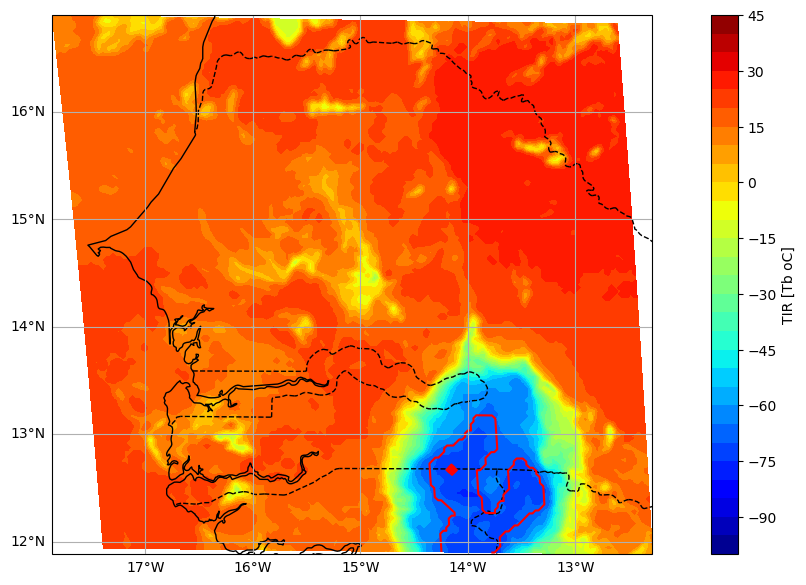

In [9]:
day = 24*19
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, tir[day,:,:], lon, lat, levels=np.arange(-100,50,5), cbar_label='TIR [Tb oC]', cmap='jet')
#ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

In [10]:
# read in input data- TIR and historical core data at t<to
# read in historical cores

list_of_file_names = []

for i in range(0,len(time_core),1):
    current_file = str(time_core[i])    #+'.nc'
    #print(current_file)
    SY= current_file[0:4]
    MM= current_file[4:6]
    DD= current_file[6:8]
    all_file_names = '/prj/Africa_cloud/hist_nflics_nowcasts/'+SY+'/'+MM+'/'+DD+'/Hist_nowcast_v1_wa_'+current_file[0:-2]+'_flt_ALL.nc' 
    #print(all_file_names)
    if os.path.isfile(all_file_names):      
        list_of_file_names.append(all_file_names) # all days in month
    else:
        list_of_file_names.append('file_not_available') # all days in month
            
                     

In [11]:
dumy_temp = np.zeros((len(lat[:,1]),len(lon[1,:])))
hist_cores = np.zeros((t*24,len(lat[:,1]),len(lon[1,:])),dtype=float) 
# hist_cores_temp= np.zeros((len(reg_lat),len(reg_lon)))*np.nan
num_of_missing_hist_core_files = 0

for l in range(0,len(list_of_file_names),1):   #2, min(t*96,len(list_of_files)), 4):#range(len(list_of_files)): # 96 files per day
    core_filename = list_of_file_names[l]   #'/prj/Africa_cloud/ch9_wavelet/'+str(i)+'/'+month+'/'  list_of_files[l]
    print(core_filename)
    if os.path.isfile(core_filename):      
        ds = xr.open_dataset(core_filename).squeeze() # pick any convective core file from ch9_wavelet. 
        print(l)
        hist_cores_temp = ds['freq'][1,0,:,:].values
        hist_cores[l,:,:] = hist_cores_temp[lat_ind[0]:lat_ind[-1]+1,lon_ind[0]:lon_ind[-1]+1]
        #hist_cores[l,:,:] = ds['freq'][1,:,:].values
        #time_core[l] = str(core_filename[-15:-3])
        
    else:
        num_of_missing_hist_core_files = num_of_missing_hist_core_files +1
        cores[l,:,:] = dumy_temp
        #tir[l,:,:] = hist_cores_temp 
        #time_core[l] = np.nan#str(core_filename[-15:-3])
        
        

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010000_flt_ALL.nc
0
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010100_flt_ALL.nc
1
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010200_flt_ALL.nc
2
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010300_flt_ALL.nc
3
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010400_flt_ALL.nc
4
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010500_flt_ALL.nc
5
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010600_flt_ALL.nc
6
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010700_flt_ALL.nc
7
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010800_flt_ALL.nc
8
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/Hist_nowcast_v1_wa_201006010900_flt_ALL.nc
9
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/01/

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041400_flt_ALL.nc
86
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041500_flt_ALL.nc
87
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041600_flt_ALL.nc
88
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041700_flt_ALL.nc
89
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041800_flt_ALL.nc
90
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006041900_flt_ALL.nc
91
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006042000_flt_ALL.nc
92
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006042100_flt_ALL.nc
93
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006042200_flt_ALL.nc
94
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/04/Hist_nowcast_v1_wa_201006042300_flt_ALL.nc
95
/prj/Africa_cloud/hist_nflics_nowcasts/2

170
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080300_flt_ALL.nc
171
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080400_flt_ALL.nc
172
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080500_flt_ALL.nc
173
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080600_flt_ALL.nc
174
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080700_flt_ALL.nc
175
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080800_flt_ALL.nc
176
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006080900_flt_ALL.nc
177
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006081000_flt_ALL.nc
178
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006081100_flt_ALL.nc
179
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/08/Hist_nowcast_v1_wa_201006081200_flt_ALL.nc
180
/prj/Africa_cloud/hist_nfl

257
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111800_flt_ALL.nc
258
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006111900_flt_ALL.nc
259
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006112000_flt_ALL.nc
260
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006112100_flt_ALL.nc
261
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006112200_flt_ALL.nc
262
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/11/Hist_nowcast_v1_wa_201006112300_flt_ALL.nc
263
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/12/Hist_nowcast_v1_wa_201006120000_flt_ALL.nc
264
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/12/Hist_nowcast_v1_wa_201006120100_flt_ALL.nc
265
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/12/Hist_nowcast_v1_wa_201006120200_flt_ALL.nc
266
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/12/Hist_nowcast_v1_wa_201006120300_flt_ALL.nc
267
/prj/Africa_cloud/hist_nfl

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151100_flt_ALL.nc
347
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151200_flt_ALL.nc
348
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151300_flt_ALL.nc
349
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151400_flt_ALL.nc
350
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151500_flt_ALL.nc
351
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151600_flt_ALL.nc
352
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151700_flt_ALL.nc
353
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151800_flt_ALL.nc
354
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006151900_flt_ALL.nc
355
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/15/Hist_nowcast_v1_wa_201006152000_flt_ALL.nc
356
/prj/Africa_cloud/hist_nflics_

432
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190100_flt_ALL.nc
433
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190200_flt_ALL.nc
434
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190300_flt_ALL.nc
435
file_not_available
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190500_flt_ALL.nc
437
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190600_flt_ALL.nc
438
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190700_flt_ALL.nc
439
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190800_flt_ALL.nc
440
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006190900_flt_ALL.nc
441
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006191000_flt_ALL.nc
442
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/19/Hist_nowcast_v1_wa_201006191100_flt_ALL.nc
443
file_no

519
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221600_flt_ALL.nc
520
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221700_flt_ALL.nc
521
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221800_flt_ALL.nc
522
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006221900_flt_ALL.nc
523
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006222000_flt_ALL.nc
524
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006222100_flt_ALL.nc
525
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006222200_flt_ALL.nc
526
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/22/Hist_nowcast_v1_wa_201006222300_flt_ALL.nc
527
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/23/Hist_nowcast_v1_wa_201006230000_flt_ALL.nc
528
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/23/Hist_nowcast_v1_wa_201006230100_flt_ALL.nc
529
/prj/Africa_cloud/hist_nfl

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260500_flt_ALL.nc
605
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260600_flt_ALL.nc
606
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260700_flt_ALL.nc
607
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260800_flt_ALL.nc
608
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006260900_flt_ALL.nc
609
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006261000_flt_ALL.nc
610
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006261100_flt_ALL.nc
611
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006261200_flt_ALL.nc
612
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006261300_flt_ALL.nc
613
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/26/Hist_nowcast_v1_wa_201006261400_flt_ALL.nc
614
/prj/Africa_cloud/hist_nflics_

/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006291800_flt_ALL.nc
690
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006291900_flt_ALL.nc
691
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006292000_flt_ALL.nc
692
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006292100_flt_ALL.nc
693
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006292200_flt_ALL.nc
694
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/29/Hist_nowcast_v1_wa_201006292300_flt_ALL.nc
695
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/30/Hist_nowcast_v1_wa_201006300000_flt_ALL.nc
696
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/30/Hist_nowcast_v1_wa_201006300100_flt_ALL.nc
697
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/30/Hist_nowcast_v1_wa_201006300200_flt_ALL.nc
698
/prj/Africa_cloud/hist_nflics_nowcasts/2010/06/30/Hist_nowcast_v1_wa_201006300300_flt_ALL.nc
699
/prj/Africa_cloud/hist_nflics_

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007030700_flt_ALL.nc
775
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007030800_flt_ALL.nc
776
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007030900_flt_ALL.nc
777
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031000_flt_ALL.nc
778
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031100_flt_ALL.nc
779
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031200_flt_ALL.nc
780
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031300_flt_ALL.nc
781
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031400_flt_ALL.nc
782
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031500_flt_ALL.nc
783
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/03/Hist_nowcast_v1_wa_201007031600_flt_ALL.nc
784
/prj/Africa_cloud/hist_nflics_

860
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007062100_flt_ALL.nc
861
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007062200_flt_ALL.nc
862
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/06/Hist_nowcast_v1_wa_201007062300_flt_ALL.nc
863
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070000_flt_ALL.nc
864
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070100_flt_ALL.nc
865
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070200_flt_ALL.nc
866
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070300_flt_ALL.nc
867
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070400_flt_ALL.nc
868
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070500_flt_ALL.nc
869
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/07/Hist_nowcast_v1_wa_201007070600_flt_ALL.nc
870
/prj/Africa_cloud/hist_nfl

/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101000_flt_ALL.nc
946
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101100_flt_ALL.nc
947
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101200_flt_ALL.nc
948
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101300_flt_ALL.nc
949
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101400_flt_ALL.nc
950
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101500_flt_ALL.nc
951
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101600_flt_ALL.nc
952
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101700_flt_ALL.nc
953
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101800_flt_ALL.nc
954
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/10/Hist_nowcast_v1_wa_201007101900_flt_ALL.nc
955
/prj/Africa_cloud/hist_nflics_

1030
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/13/Hist_nowcast_v1_wa_201007132300_flt_ALL.nc
1031
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140000_flt_ALL.nc
1032
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140100_flt_ALL.nc
1033
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140200_flt_ALL.nc
1034
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140300_flt_ALL.nc
1035
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140400_flt_ALL.nc
1036
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140500_flt_ALL.nc
1037
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140600_flt_ALL.nc
1038
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140700_flt_ALL.nc
1039
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/14/Hist_nowcast_v1_wa_201007140800_flt_ALL.nc
1040
/prj/Africa_clo

1114
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171100_flt_ALL.nc
1115
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171200_flt_ALL.nc
1116
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171300_flt_ALL.nc
1117
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171400_flt_ALL.nc
1118
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171500_flt_ALL.nc
1119
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171600_flt_ALL.nc
1120
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171700_flt_ALL.nc
1121
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171800_flt_ALL.nc
1122
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007171900_flt_ALL.nc
1123
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/17/Hist_nowcast_v1_wa_201007172000_flt_ALL.nc
1124
/prj/Africa_clo

1199
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210000_flt_ALL.nc
1200
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210100_flt_ALL.nc
1201
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210200_flt_ALL.nc
1202
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210300_flt_ALL.nc
1203
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210400_flt_ALL.nc
1204
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210500_flt_ALL.nc
1205
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210600_flt_ALL.nc
1206
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210700_flt_ALL.nc
1207
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210800_flt_ALL.nc
1208
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/21/Hist_nowcast_v1_wa_201007210900_flt_ALL.nc
1209
/prj/Africa_clo

1283
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241200_flt_ALL.nc
1284
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241300_flt_ALL.nc
1285
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241400_flt_ALL.nc
1286
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241500_flt_ALL.nc
1287
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241600_flt_ALL.nc
1288
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241700_flt_ALL.nc
1289
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241800_flt_ALL.nc
1290
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007241900_flt_ALL.nc
1291
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007242000_flt_ALL.nc
1292
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/24/Hist_nowcast_v1_wa_201007242100_flt_ALL.nc
1293
/prj/Africa_clo

1374
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280700_flt_ALL.nc
1375
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280800_flt_ALL.nc
1376
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007280900_flt_ALL.nc
1377
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281000_flt_ALL.nc
1378
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281100_flt_ALL.nc
1379
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281200_flt_ALL.nc
1380
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281300_flt_ALL.nc
1381
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281400_flt_ALL.nc
1382
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281500_flt_ALL.nc
1383
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/28/Hist_nowcast_v1_wa_201007281600_flt_ALL.nc
1384
/prj/Africa_clo

1458
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007311900_flt_ALL.nc
1459
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007312000_flt_ALL.nc
1460
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007312100_flt_ALL.nc
1461
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007312200_flt_ALL.nc
1462
/prj/Africa_cloud/hist_nflics_nowcasts/2010/07/31/Hist_nowcast_v1_wa_201007312300_flt_ALL.nc
1463
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/01/Hist_nowcast_v1_wa_201008010000_flt_ALL.nc
1464
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/01/Hist_nowcast_v1_wa_201008010100_flt_ALL.nc
1465
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/01/Hist_nowcast_v1_wa_201008010200_flt_ALL.nc
1466
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/01/Hist_nowcast_v1_wa_201008010300_flt_ALL.nc
1467
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/01/Hist_nowcast_v1_wa_201008010400_flt_ALL.nc
1468
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008040700_flt_ALL.nc
1543
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008040800_flt_ALL.nc
1544
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008040900_flt_ALL.nc
1545
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041000_flt_ALL.nc
1546
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041100_flt_ALL.nc
1547
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041200_flt_ALL.nc
1548
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041300_flt_ALL.nc
1549
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041400_flt_ALL.nc
1550
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041500_flt_ALL.nc
1551
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/04/Hist_nowcast_v1_wa_201008041600_flt_ALL.nc
1552
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008071900_flt_ALL.nc
1627
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008072000_flt_ALL.nc
1628
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008072100_flt_ALL.nc
1629
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008072200_flt_ALL.nc
1630
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/07/Hist_nowcast_v1_wa_201008072300_flt_ALL.nc
1631
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/08/Hist_nowcast_v1_wa_201008080000_flt_ALL.nc
1632
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/08/Hist_nowcast_v1_wa_201008080100_flt_ALL.nc
1633
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/08/Hist_nowcast_v1_wa_201008080200_flt_ALL.nc
1634
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/08/Hist_nowcast_v1_wa_201008080300_flt_ALL.nc
1635
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/08/Hist_nowcast_v1_wa_201008080400_flt_ALL.nc
1636
/prj/Africa_cloud/hi

1711
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008110800_flt_ALL.nc
1712
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008110900_flt_ALL.nc
1713
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111000_flt_ALL.nc
1714
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111100_flt_ALL.nc
1715
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111200_flt_ALL.nc
1716
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111300_flt_ALL.nc
1717
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111400_flt_ALL.nc
1718
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111500_flt_ALL.nc
1719
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111600_flt_ALL.nc
1720
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/11/Hist_nowcast_v1_wa_201008111700_flt_ALL.nc
1721
/prj/Africa_clo

1795
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008142000_flt_ALL.nc
1796
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008142100_flt_ALL.nc
1797
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008142200_flt_ALL.nc
1798
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/14/Hist_nowcast_v1_wa_201008142300_flt_ALL.nc
1799
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/15/Hist_nowcast_v1_wa_201008150000_flt_ALL.nc
1800
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/15/Hist_nowcast_v1_wa_201008150100_flt_ALL.nc
1801
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/15/Hist_nowcast_v1_wa_201008150200_flt_ALL.nc
1802
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/15/Hist_nowcast_v1_wa_201008150300_flt_ALL.nc
1803
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/15/Hist_nowcast_v1_wa_201008150400_flt_ALL.nc
1804
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/15/Hist_nowcast_v1_wa_201008150500_flt_ALL.nc
1805
/prj/Africa_clo

1879
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008180800_flt_ALL.nc
1880
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008180900_flt_ALL.nc
1881
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181000_flt_ALL.nc
1882
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181100_flt_ALL.nc
1883
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181200_flt_ALL.nc
1884
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181300_flt_ALL.nc
1885
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181400_flt_ALL.nc
1886
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181500_flt_ALL.nc
1887
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181600_flt_ALL.nc
1888
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/18/Hist_nowcast_v1_wa_201008181700_flt_ALL.nc
1889
/prj/Africa_clo

1963
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008212000_flt_ALL.nc
1964
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008212100_flt_ALL.nc
1965
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008212200_flt_ALL.nc
1966
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/21/Hist_nowcast_v1_wa_201008212300_flt_ALL.nc
1967
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/22/Hist_nowcast_v1_wa_201008220000_flt_ALL.nc
1968
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/22/Hist_nowcast_v1_wa_201008220100_flt_ALL.nc
1969
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/22/Hist_nowcast_v1_wa_201008220200_flt_ALL.nc
1970
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/22/Hist_nowcast_v1_wa_201008220300_flt_ALL.nc
1971
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/22/Hist_nowcast_v1_wa_201008220400_flt_ALL.nc
1972
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/22/Hist_nowcast_v1_wa_201008220500_flt_ALL.nc
1973
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008250800_flt_ALL.nc
2048
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008250900_flt_ALL.nc
2049
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251000_flt_ALL.nc
2050
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251100_flt_ALL.nc
2051
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251200_flt_ALL.nc
2052
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251300_flt_ALL.nc
2053
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251400_flt_ALL.nc
2054
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251500_flt_ALL.nc
2055
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251600_flt_ALL.nc
2056
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/25/Hist_nowcast_v1_wa_201008251700_flt_ALL.nc
2057
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008282000_flt_ALL.nc
2132
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008282100_flt_ALL.nc
2133
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008282200_flt_ALL.nc
2134
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/28/Hist_nowcast_v1_wa_201008282300_flt_ALL.nc
2135
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290000_flt_ALL.nc
2136
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290100_flt_ALL.nc
2137
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290200_flt_ALL.nc
2138
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290300_flt_ALL.nc
2139
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290400_flt_ALL.nc
2140
/prj/Africa_cloud/hist_nflics_nowcasts/2010/08/29/Hist_nowcast_v1_wa_201008290500_flt_ALL.nc
2141
/prj/Africa_cloud/hi

2215
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010800_flt_ALL.nc
2216
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009010900_flt_ALL.nc
2217
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011000_flt_ALL.nc
2218
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011100_flt_ALL.nc
2219
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011200_flt_ALL.nc
2220
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011300_flt_ALL.nc
2221
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011400_flt_ALL.nc
2222
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011500_flt_ALL.nc
2223
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011600_flt_ALL.nc
2224
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/01/Hist_nowcast_v1_wa_201009011700_flt_ALL.nc
2225
/prj/Africa_clo

2300
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009042100_flt_ALL.nc
2301
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009042200_flt_ALL.nc
2302
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/04/Hist_nowcast_v1_wa_201009042300_flt_ALL.nc
2303
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050000_flt_ALL.nc
2304
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050100_flt_ALL.nc
2305
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050200_flt_ALL.nc
2306
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050300_flt_ALL.nc
2307
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050400_flt_ALL.nc
2308
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050500_flt_ALL.nc
2309
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/05/Hist_nowcast_v1_wa_201009050600_flt_ALL.nc
2310
/prj/Africa_clo

2384
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009080900_flt_ALL.nc
2385
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081000_flt_ALL.nc
2386
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081100_flt_ALL.nc
2387
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081200_flt_ALL.nc
2388
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081300_flt_ALL.nc
2389
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081400_flt_ALL.nc
2390
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081500_flt_ALL.nc
2391
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081600_flt_ALL.nc
2392
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081700_flt_ALL.nc
2393
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/08/Hist_nowcast_v1_wa_201009081800_flt_ALL.nc
2394
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009112100_flt_ALL.nc
2469
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009112200_flt_ALL.nc
2470
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/11/Hist_nowcast_v1_wa_201009112300_flt_ALL.nc
2471
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120000_flt_ALL.nc
2472
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120100_flt_ALL.nc
2473
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120200_flt_ALL.nc
2474
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120300_flt_ALL.nc
2475
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120400_flt_ALL.nc
2476
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120500_flt_ALL.nc
2477
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/12/Hist_nowcast_v1_wa_201009120600_flt_ALL.nc
2478
/prj/Africa_cloud/hi

2552
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009150900_flt_ALL.nc
2553
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151000_flt_ALL.nc
2554
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151100_flt_ALL.nc
2555
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151200_flt_ALL.nc
2556
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151300_flt_ALL.nc
2557
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151400_flt_ALL.nc
2558
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151500_flt_ALL.nc
2559
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151600_flt_ALL.nc
2560
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151700_flt_ALL.nc
2561
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/15/Hist_nowcast_v1_wa_201009151800_flt_ALL.nc
2562
/prj/Africa_clo

2636
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009182100_flt_ALL.nc
2637
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009182200_flt_ALL.nc
2638
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/18/Hist_nowcast_v1_wa_201009182300_flt_ALL.nc
2639
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190000_flt_ALL.nc
2640
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190100_flt_ALL.nc
2641
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190200_flt_ALL.nc
2642
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190300_flt_ALL.nc
2643
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190400_flt_ALL.nc
2644
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190500_flt_ALL.nc
2645
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/19/Hist_nowcast_v1_wa_201009190600_flt_ALL.nc
2646
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009220900_flt_ALL.nc
2721
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221000_flt_ALL.nc
2722
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221100_flt_ALL.nc
2723
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221200_flt_ALL.nc
2724
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221300_flt_ALL.nc
2725
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221400_flt_ALL.nc
2726
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221500_flt_ALL.nc
2727
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221600_flt_ALL.nc
2728
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221700_flt_ALL.nc
2729
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/22/Hist_nowcast_v1_wa_201009221800_flt_ALL.nc
2730
/prj/Africa_cloud/hi

2805
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009252200_flt_ALL.nc
2806
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/25/Hist_nowcast_v1_wa_201009252300_flt_ALL.nc
2807
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260000_flt_ALL.nc
2808
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260100_flt_ALL.nc
2809
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260200_flt_ALL.nc
2810
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260300_flt_ALL.nc
2811
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260400_flt_ALL.nc
2812
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260500_flt_ALL.nc
2813
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260600_flt_ALL.nc
2814
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/26/Hist_nowcast_v1_wa_201009260700_flt_ALL.nc
2815
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291100_flt_ALL.nc
2891
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291200_flt_ALL.nc
2892
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291300_flt_ALL.nc
2893
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291400_flt_ALL.nc
2894
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291500_flt_ALL.nc
2895
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291600_flt_ALL.nc
2896
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291700_flt_ALL.nc
2897
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291800_flt_ALL.nc
2898
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009291900_flt_ALL.nc
2899
/prj/Africa_cloud/hist_nflics_nowcasts/2010/09/29/Hist_nowcast_v1_wa_201009292000_flt_ALL.nc
2900
/prj/Africa_cloud/hi

2974
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/02/Hist_nowcast_v1_wa_201106022300_flt_ALL.nc
2975
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/03/Hist_nowcast_v1_wa_201106030000_flt_ALL.nc
2976
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/03/Hist_nowcast_v1_wa_201106030100_flt_ALL.nc
2977
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/03/Hist_nowcast_v1_wa_201106030200_flt_ALL.nc
2978
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/03/Hist_nowcast_v1_wa_201106030300_flt_ALL.nc
2979
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/03/Hist_nowcast_v1_wa_201106030400_flt_ALL.nc
2980
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/03/Hist_nowcast_v1_wa_201106030500_flt_ALL.nc
2981
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/03/Hist_nowcast_v1_wa_201106030600_flt_ALL.nc
2982
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/03/Hist_nowcast_v1_wa_201106030700_flt_ALL.nc
2983
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/03/Hist_nowcast_v1_wa_201106030800_flt_ALL.nc
2984
/prj/Africa_clo

3059
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106061200_flt_ALL.nc
3060
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106061300_flt_ALL.nc
3061
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106061400_flt_ALL.nc
3062
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106061500_flt_ALL.nc
3063
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106061600_flt_ALL.nc
3064
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106061700_flt_ALL.nc
3065
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106061800_flt_ALL.nc
3066
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106061900_flt_ALL.nc
3067
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106062000_flt_ALL.nc
3068
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/06/Hist_nowcast_v1_wa_201106062100_flt_ALL.nc
3069
/prj/Africa_clo

3143
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/10/Hist_nowcast_v1_wa_201106100000_flt_ALL.nc
3144
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/10/Hist_nowcast_v1_wa_201106100100_flt_ALL.nc
3145
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/10/Hist_nowcast_v1_wa_201106100200_flt_ALL.nc
3146
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/10/Hist_nowcast_v1_wa_201106100300_flt_ALL.nc
3147
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/10/Hist_nowcast_v1_wa_201106100400_flt_ALL.nc
3148
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/10/Hist_nowcast_v1_wa_201106100500_flt_ALL.nc
3149
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/10/Hist_nowcast_v1_wa_201106100600_flt_ALL.nc
3150
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/10/Hist_nowcast_v1_wa_201106100700_flt_ALL.nc
3151
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/10/Hist_nowcast_v1_wa_201106100800_flt_ALL.nc
3152
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/10/Hist_nowcast_v1_wa_201106100900_flt_ALL.nc
3153
/prj/Africa_clo

3228
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106131300_flt_ALL.nc
3229
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106131400_flt_ALL.nc
3230
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106131500_flt_ALL.nc
3231
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106131600_flt_ALL.nc
3232
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106131700_flt_ALL.nc
3233
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106131800_flt_ALL.nc
3234
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106131900_flt_ALL.nc
3235
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106132000_flt_ALL.nc
3236
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106132100_flt_ALL.nc
3237
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/13/Hist_nowcast_v1_wa_201106132200_flt_ALL.nc
3238
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106170100_flt_ALL.nc
3313
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106170200_flt_ALL.nc
3314
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106170300_flt_ALL.nc
3315
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106170400_flt_ALL.nc
3316
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106170500_flt_ALL.nc
3317
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106170600_flt_ALL.nc
3318
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106170700_flt_ALL.nc
3319
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106170800_flt_ALL.nc
3320
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106170900_flt_ALL.nc
3321
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/17/Hist_nowcast_v1_wa_201106171000_flt_ALL.nc
3322
/prj/Africa_cloud/hi

3397
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106201400_flt_ALL.nc
3398
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106201500_flt_ALL.nc
3399
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106201600_flt_ALL.nc
3400
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106201700_flt_ALL.nc
3401
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106201800_flt_ALL.nc
3402
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106201900_flt_ALL.nc
3403
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106202000_flt_ALL.nc
3404
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106202100_flt_ALL.nc
3405
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106202200_flt_ALL.nc
3406
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/20/Hist_nowcast_v1_wa_201106202300_flt_ALL.nc
3407
/prj/Africa_clo

3482
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106240300_flt_ALL.nc
3483
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106240400_flt_ALL.nc
3484
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106240500_flt_ALL.nc
3485
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106240600_flt_ALL.nc
3486
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106240700_flt_ALL.nc
3487
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106240800_flt_ALL.nc
3488
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106240900_flt_ALL.nc
3489
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106241000_flt_ALL.nc
3490
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106241100_flt_ALL.nc
3491
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/24/Hist_nowcast_v1_wa_201106241200_flt_ALL.nc
3492
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106271500_flt_ALL.nc
3567
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106271600_flt_ALL.nc
3568
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106271700_flt_ALL.nc
3569
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106271800_flt_ALL.nc
3570
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106271900_flt_ALL.nc
3571
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106272000_flt_ALL.nc
3572
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106272100_flt_ALL.nc
3573
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106272200_flt_ALL.nc
3574
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/27/Hist_nowcast_v1_wa_201106272300_flt_ALL.nc
3575
/prj/Africa_cloud/hist_nflics_nowcasts/2011/06/28/Hist_nowcast_v1_wa_201106280000_flt_ALL.nc
3576
/prj/Africa_cloud/hi

3650
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107010300_flt_ALL.nc
3651
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107010400_flt_ALL.nc
3652
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107010500_flt_ALL.nc
3653
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107010600_flt_ALL.nc
3654
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107010700_flt_ALL.nc
3655
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107010800_flt_ALL.nc
3656
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107010900_flt_ALL.nc
3657
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107011000_flt_ALL.nc
3658
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107011100_flt_ALL.nc
3659
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/01/Hist_nowcast_v1_wa_201107011200_flt_ALL.nc
3660
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107041500_flt_ALL.nc
3735
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107041600_flt_ALL.nc
3736
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107041700_flt_ALL.nc
3737
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107041800_flt_ALL.nc
3738
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107041900_flt_ALL.nc
3739
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107042000_flt_ALL.nc
3740
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107042100_flt_ALL.nc
3741
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107042200_flt_ALL.nc
3742
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/04/Hist_nowcast_v1_wa_201107042300_flt_ALL.nc
3743
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/05/Hist_nowcast_v1_wa_201107050000_flt_ALL.nc
3744
/prj/Africa_cloud/hi

3818
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107080300_flt_ALL.nc
3819
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107080400_flt_ALL.nc
3820
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107080500_flt_ALL.nc
3821
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107080600_flt_ALL.nc
3822
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107080700_flt_ALL.nc
3823
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107080800_flt_ALL.nc
3824
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107080900_flt_ALL.nc
3825
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107081000_flt_ALL.nc
3826
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107081100_flt_ALL.nc
3827
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/08/Hist_nowcast_v1_wa_201107081200_flt_ALL.nc
3828
/prj/Africa_clo

3902
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107111500_flt_ALL.nc
3903
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107111600_flt_ALL.nc
3904
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107111700_flt_ALL.nc
3905
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107111800_flt_ALL.nc
3906
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107111900_flt_ALL.nc
3907
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107112000_flt_ALL.nc
3908
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107112100_flt_ALL.nc
3909
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107112200_flt_ALL.nc
3910
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/11/Hist_nowcast_v1_wa_201107112300_flt_ALL.nc
3911
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/12/Hist_nowcast_v1_wa_201107120000_flt_ALL.nc
3912
/prj/Africa_clo

3994
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107151100_flt_ALL.nc
3995
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107151200_flt_ALL.nc
3996
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107151300_flt_ALL.nc
3997
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107151400_flt_ALL.nc
3998
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107151500_flt_ALL.nc
3999
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107151600_flt_ALL.nc
4000
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107151700_flt_ALL.nc
4001
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107151800_flt_ALL.nc
4002
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107151900_flt_ALL.nc
4003
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/15/Hist_nowcast_v1_wa_201107152000_flt_ALL.nc
4004
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/18/Hist_nowcast_v1_wa_201107182300_flt_ALL.nc
4079
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/19/Hist_nowcast_v1_wa_201107190000_flt_ALL.nc
4080
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/19/Hist_nowcast_v1_wa_201107190100_flt_ALL.nc
4081
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/19/Hist_nowcast_v1_wa_201107190200_flt_ALL.nc
4082
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/19/Hist_nowcast_v1_wa_201107190300_flt_ALL.nc
4083
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/19/Hist_nowcast_v1_wa_201107190400_flt_ALL.nc
4084
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/19/Hist_nowcast_v1_wa_201107190500_flt_ALL.nc
4085
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/19/Hist_nowcast_v1_wa_201107190600_flt_ALL.nc
4086
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/19/Hist_nowcast_v1_wa_201107190700_flt_ALL.nc
4087
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/19/Hist_nowcast_v1_wa_201107190800_flt_ALL.nc
4088
/prj/Africa_cloud/hi

4163
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107221200_flt_ALL.nc
4164
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107221300_flt_ALL.nc
4165
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107221400_flt_ALL.nc
4166
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107221500_flt_ALL.nc
4167
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107221600_flt_ALL.nc
4168
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107221700_flt_ALL.nc
4169
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107221800_flt_ALL.nc
4170
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107221900_flt_ALL.nc
4171
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107222000_flt_ALL.nc
4172
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/22/Hist_nowcast_v1_wa_201107222100_flt_ALL.nc
4173
/prj/Africa_clo

4247
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/26/Hist_nowcast_v1_wa_201107260000_flt_ALL.nc
4248
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/26/Hist_nowcast_v1_wa_201107260100_flt_ALL.nc
4249
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/26/Hist_nowcast_v1_wa_201107260200_flt_ALL.nc
4250
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/26/Hist_nowcast_v1_wa_201107260300_flt_ALL.nc
4251
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/26/Hist_nowcast_v1_wa_201107260400_flt_ALL.nc
4252
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/26/Hist_nowcast_v1_wa_201107260500_flt_ALL.nc
4253
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/26/Hist_nowcast_v1_wa_201107260600_flt_ALL.nc
4254
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/26/Hist_nowcast_v1_wa_201107260700_flt_ALL.nc
4255
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/26/Hist_nowcast_v1_wa_201107260800_flt_ALL.nc
4256
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/26/Hist_nowcast_v1_wa_201107260900_flt_ALL.nc
4257
/prj/Africa_clo

4331
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107291200_flt_ALL.nc
4332
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107291300_flt_ALL.nc
4333
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107291400_flt_ALL.nc
4334
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107291500_flt_ALL.nc
4335
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107291600_flt_ALL.nc
4336
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107291700_flt_ALL.nc
4337
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107291800_flt_ALL.nc
4338
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107291900_flt_ALL.nc
4339
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107292000_flt_ALL.nc
4340
/prj/Africa_cloud/hist_nflics_nowcasts/2011/07/29/Hist_nowcast_v1_wa_201107292100_flt_ALL.nc
4341
/prj/Africa_clo

4415
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/02/Hist_nowcast_v1_wa_201108020000_flt_ALL.nc
4416
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/02/Hist_nowcast_v1_wa_201108020100_flt_ALL.nc
4417
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/02/Hist_nowcast_v1_wa_201108020200_flt_ALL.nc
4418
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/02/Hist_nowcast_v1_wa_201108020300_flt_ALL.nc
4419
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/02/Hist_nowcast_v1_wa_201108020400_flt_ALL.nc
4420
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/02/Hist_nowcast_v1_wa_201108020500_flt_ALL.nc
4421
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/02/Hist_nowcast_v1_wa_201108020600_flt_ALL.nc
4422
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/02/Hist_nowcast_v1_wa_201108020700_flt_ALL.nc
4423
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/02/Hist_nowcast_v1_wa_201108020800_flt_ALL.nc
4424
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/02/Hist_nowcast_v1_wa_201108020900_flt_ALL.nc
4425
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108051200_flt_ALL.nc
4500
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108051300_flt_ALL.nc
4501
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108051400_flt_ALL.nc
4502
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108051500_flt_ALL.nc
4503
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108051600_flt_ALL.nc
4504
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108051700_flt_ALL.nc
4505
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108051800_flt_ALL.nc
4506
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108051900_flt_ALL.nc
4507
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108052000_flt_ALL.nc
4508
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/05/Hist_nowcast_v1_wa_201108052100_flt_ALL.nc
4509
/prj/Africa_cloud/hi

4583
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/09/Hist_nowcast_v1_wa_201108090000_flt_ALL.nc
4584
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/09/Hist_nowcast_v1_wa_201108090100_flt_ALL.nc
4585
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/09/Hist_nowcast_v1_wa_201108090200_flt_ALL.nc
4586
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/09/Hist_nowcast_v1_wa_201108090300_flt_ALL.nc
4587
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/09/Hist_nowcast_v1_wa_201108090400_flt_ALL.nc
4588
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/09/Hist_nowcast_v1_wa_201108090500_flt_ALL.nc
4589
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/09/Hist_nowcast_v1_wa_201108090600_flt_ALL.nc
4590
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/09/Hist_nowcast_v1_wa_201108090700_flt_ALL.nc
4591
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/09/Hist_nowcast_v1_wa_201108090800_flt_ALL.nc
4592
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/09/Hist_nowcast_v1_wa_201108090900_flt_ALL.nc
4593
/prj/Africa_clo

4667
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108121200_flt_ALL.nc
4668
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108121300_flt_ALL.nc
4669
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108121400_flt_ALL.nc
4670
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108121500_flt_ALL.nc
4671
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108121600_flt_ALL.nc
4672
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108121700_flt_ALL.nc
4673
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108121800_flt_ALL.nc
4674
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108121900_flt_ALL.nc
4675
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108122000_flt_ALL.nc
4676
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/12/Hist_nowcast_v1_wa_201108122100_flt_ALL.nc
4677
/prj/Africa_clo

4751
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/16/Hist_nowcast_v1_wa_201108160000_flt_ALL.nc
4752
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/16/Hist_nowcast_v1_wa_201108160100_flt_ALL.nc
4753
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/16/Hist_nowcast_v1_wa_201108160200_flt_ALL.nc
4754
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/16/Hist_nowcast_v1_wa_201108160300_flt_ALL.nc
4755
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/16/Hist_nowcast_v1_wa_201108160400_flt_ALL.nc
4756
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/16/Hist_nowcast_v1_wa_201108160500_flt_ALL.nc
4757
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/16/Hist_nowcast_v1_wa_201108160600_flt_ALL.nc
4758
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/16/Hist_nowcast_v1_wa_201108160700_flt_ALL.nc
4759
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/16/Hist_nowcast_v1_wa_201108160800_flt_ALL.nc
4760
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/16/Hist_nowcast_v1_wa_201108160900_flt_ALL.nc
4761
/prj/Africa_clo

4835
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108191200_flt_ALL.nc
4836
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108191300_flt_ALL.nc
4837
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108191400_flt_ALL.nc
4838
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108191500_flt_ALL.nc
4839
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108191600_flt_ALL.nc
4840
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108191700_flt_ALL.nc
4841
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108191800_flt_ALL.nc
4842
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108191900_flt_ALL.nc
4843
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108192000_flt_ALL.nc
4844
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/19/Hist_nowcast_v1_wa_201108192100_flt_ALL.nc
4845
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/23/Hist_nowcast_v1_wa_201108230000_flt_ALL.nc
4920
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/23/Hist_nowcast_v1_wa_201108230100_flt_ALL.nc
4921
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/23/Hist_nowcast_v1_wa_201108230200_flt_ALL.nc
4922
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/23/Hist_nowcast_v1_wa_201108230300_flt_ALL.nc
4923
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/23/Hist_nowcast_v1_wa_201108230400_flt_ALL.nc
4924
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/23/Hist_nowcast_v1_wa_201108230500_flt_ALL.nc
4925
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/23/Hist_nowcast_v1_wa_201108230600_flt_ALL.nc
4926
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/23/Hist_nowcast_v1_wa_201108230700_flt_ALL.nc
4927
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/23/Hist_nowcast_v1_wa_201108230800_flt_ALL.nc
4928
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/23/Hist_nowcast_v1_wa_201108230900_flt_ALL.nc
4929
/prj/Africa_cloud/hi

5003
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108261200_flt_ALL.nc
5004
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108261300_flt_ALL.nc
5005
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108261400_flt_ALL.nc
5006
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108261500_flt_ALL.nc
5007
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108261600_flt_ALL.nc
5008
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108261700_flt_ALL.nc
5009
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108261800_flt_ALL.nc
5010
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108261900_flt_ALL.nc
5011
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108262000_flt_ALL.nc
5012
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/26/Hist_nowcast_v1_wa_201108262100_flt_ALL.nc
5013
/prj/Africa_clo

5087
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/30/Hist_nowcast_v1_wa_201108300000_flt_ALL.nc
5088
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/30/Hist_nowcast_v1_wa_201108300100_flt_ALL.nc
5089
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/30/Hist_nowcast_v1_wa_201108300200_flt_ALL.nc
5090
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/30/Hist_nowcast_v1_wa_201108300300_flt_ALL.nc
5091
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/30/Hist_nowcast_v1_wa_201108300400_flt_ALL.nc
5092
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/30/Hist_nowcast_v1_wa_201108300500_flt_ALL.nc
5093
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/30/Hist_nowcast_v1_wa_201108300600_flt_ALL.nc
5094
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/30/Hist_nowcast_v1_wa_201108300700_flt_ALL.nc
5095
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/30/Hist_nowcast_v1_wa_201108300800_flt_ALL.nc
5096
/prj/Africa_cloud/hist_nflics_nowcasts/2011/08/30/Hist_nowcast_v1_wa_201108300900_flt_ALL.nc
5097
/prj/Africa_clo

5171
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109021200_flt_ALL.nc
5172
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109021300_flt_ALL.nc
5173
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109021400_flt_ALL.nc
5174
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109021500_flt_ALL.nc
5175
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109021600_flt_ALL.nc
5176
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109021700_flt_ALL.nc
5177
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109021800_flt_ALL.nc
5178
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109021900_flt_ALL.nc
5179
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109022000_flt_ALL.nc
5180
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/02/Hist_nowcast_v1_wa_201109022100_flt_ALL.nc
5181
/prj/Africa_clo

5256
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/06/Hist_nowcast_v1_wa_201109060100_flt_ALL.nc
5257
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/06/Hist_nowcast_v1_wa_201109060200_flt_ALL.nc
5258
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/06/Hist_nowcast_v1_wa_201109060300_flt_ALL.nc
5259
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/06/Hist_nowcast_v1_wa_201109060400_flt_ALL.nc
5260
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/06/Hist_nowcast_v1_wa_201109060500_flt_ALL.nc
5261
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/06/Hist_nowcast_v1_wa_201109060600_flt_ALL.nc
5262
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/06/Hist_nowcast_v1_wa_201109060700_flt_ALL.nc
5263
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/06/Hist_nowcast_v1_wa_201109060800_flt_ALL.nc
5264
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/06/Hist_nowcast_v1_wa_201109060900_flt_ALL.nc
5265
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/06/Hist_nowcast_v1_wa_201109061000_flt_ALL.nc
5266
/prj/Africa_clo

5340
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109091300_flt_ALL.nc
5341
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109091400_flt_ALL.nc
5342
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109091500_flt_ALL.nc
5343
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109091600_flt_ALL.nc
5344
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109091700_flt_ALL.nc
5345
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109091800_flt_ALL.nc
5346
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109091900_flt_ALL.nc
5347
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109092000_flt_ALL.nc
5348
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109092100_flt_ALL.nc
5349
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/09/Hist_nowcast_v1_wa_201109092200_flt_ALL.nc
5350
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/13/Hist_nowcast_v1_wa_201109130100_flt_ALL.nc
5425
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/13/Hist_nowcast_v1_wa_201109130200_flt_ALL.nc
5426
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/13/Hist_nowcast_v1_wa_201109130300_flt_ALL.nc
5427
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/13/Hist_nowcast_v1_wa_201109130400_flt_ALL.nc
5428
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/13/Hist_nowcast_v1_wa_201109130500_flt_ALL.nc
5429
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/13/Hist_nowcast_v1_wa_201109130600_flt_ALL.nc
5430
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/13/Hist_nowcast_v1_wa_201109130700_flt_ALL.nc
5431
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/13/Hist_nowcast_v1_wa_201109130800_flt_ALL.nc
5432
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/13/Hist_nowcast_v1_wa_201109130900_flt_ALL.nc
5433
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/13/Hist_nowcast_v1_wa_201109131000_flt_ALL.nc
5434
/prj/Africa_cloud/hi

5508
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109161300_flt_ALL.nc
5509
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109161400_flt_ALL.nc
5510
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109161500_flt_ALL.nc
5511
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109161600_flt_ALL.nc
5512
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109161700_flt_ALL.nc
5513
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109161800_flt_ALL.nc
5514
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109161900_flt_ALL.nc
5515
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109162000_flt_ALL.nc
5516
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109162100_flt_ALL.nc
5517
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/16/Hist_nowcast_v1_wa_201109162200_flt_ALL.nc
5518
/prj/Africa_clo

5592
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/20/Hist_nowcast_v1_wa_201109200100_flt_ALL.nc
5593
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/20/Hist_nowcast_v1_wa_201109200200_flt_ALL.nc
5594
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/20/Hist_nowcast_v1_wa_201109200300_flt_ALL.nc
5595
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/20/Hist_nowcast_v1_wa_201109200400_flt_ALL.nc
5596
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/20/Hist_nowcast_v1_wa_201109200500_flt_ALL.nc
5597
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/20/Hist_nowcast_v1_wa_201109200600_flt_ALL.nc
5598
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/20/Hist_nowcast_v1_wa_201109200700_flt_ALL.nc
5599
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/20/Hist_nowcast_v1_wa_201109200800_flt_ALL.nc
5600
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/20/Hist_nowcast_v1_wa_201109200900_flt_ALL.nc
5601
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/20/Hist_nowcast_v1_wa_201109201000_flt_ALL.nc
5602
/prj/Africa_clo

5676
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109231300_flt_ALL.nc
5677
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109231400_flt_ALL.nc
5678
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109231500_flt_ALL.nc
5679
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109231600_flt_ALL.nc
5680
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109231700_flt_ALL.nc
5681
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109231800_flt_ALL.nc
5682
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109231900_flt_ALL.nc
5683
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109232000_flt_ALL.nc
5684
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109232100_flt_ALL.nc
5685
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/23/Hist_nowcast_v1_wa_201109232200_flt_ALL.nc
5686
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109270300_flt_ALL.nc
5763
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109270400_flt_ALL.nc
5764
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109270500_flt_ALL.nc
5765
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109270600_flt_ALL.nc
5766
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109270700_flt_ALL.nc
5767
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109270800_flt_ALL.nc
5768
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109270900_flt_ALL.nc
5769
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109271000_flt_ALL.nc
5770
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109271100_flt_ALL.nc
5771
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/27/Hist_nowcast_v1_wa_201109271200_flt_ALL.nc
5772
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109301500_flt_ALL.nc
5847
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109301600_flt_ALL.nc
5848
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109301700_flt_ALL.nc
5849
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109301800_flt_ALL.nc
5850
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109301900_flt_ALL.nc
5851
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109302000_flt_ALL.nc
5852
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109302100_flt_ALL.nc
5853
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109302200_flt_ALL.nc
5854
/prj/Africa_cloud/hist_nflics_nowcasts/2011/09/30/Hist_nowcast_v1_wa_201109302300_flt_ALL.nc
5855
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/01/Hist_nowcast_v1_wa_201206010000_flt_ALL.nc
5856
/prj/Africa_cloud/hi

5931
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206040400_flt_ALL.nc
5932
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206040500_flt_ALL.nc
5933
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206040600_flt_ALL.nc
5934
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206040700_flt_ALL.nc
5935
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206040800_flt_ALL.nc
5936
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206040900_flt_ALL.nc
5937
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206041000_flt_ALL.nc
5938
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206041100_flt_ALL.nc
5939
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206041200_flt_ALL.nc
5940
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/04/Hist_nowcast_v1_wa_201206041300_flt_ALL.nc
5941
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206071600_flt_ALL.nc
6016
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206071700_flt_ALL.nc
6017
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206071800_flt_ALL.nc
6018
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206071900_flt_ALL.nc
6019
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206072000_flt_ALL.nc
6020
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206072100_flt_ALL.nc
6021
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206072200_flt_ALL.nc
6022
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/07/Hist_nowcast_v1_wa_201206072300_flt_ALL.nc
6023
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/08/Hist_nowcast_v1_wa_201206080000_flt_ALL.nc
6024
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/08/Hist_nowcast_v1_wa_201206080100_flt_ALL.nc
6025
/prj/Africa_cloud/hi

6103
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206110800_flt_ALL.nc
6104
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206110900_flt_ALL.nc
6105
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206111000_flt_ALL.nc
6106
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206111100_flt_ALL.nc
6107
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206111200_flt_ALL.nc
6108
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206111300_flt_ALL.nc
6109
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206111400_flt_ALL.nc
6110
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206111500_flt_ALL.nc
6111
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206111600_flt_ALL.nc
6112
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/11/Hist_nowcast_v1_wa_201206111700_flt_ALL.nc
6113
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206142000_flt_ALL.nc
6188
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206142100_flt_ALL.nc
6189
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206142200_flt_ALL.nc
6190
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/14/Hist_nowcast_v1_wa_201206142300_flt_ALL.nc
6191
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/15/Hist_nowcast_v1_wa_201206150000_flt_ALL.nc
6192
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/15/Hist_nowcast_v1_wa_201206150100_flt_ALL.nc
6193
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/15/Hist_nowcast_v1_wa_201206150200_flt_ALL.nc
6194
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/15/Hist_nowcast_v1_wa_201206150300_flt_ALL.nc
6195
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/15/Hist_nowcast_v1_wa_201206150400_flt_ALL.nc
6196
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/15/Hist_nowcast_v1_wa_201206150500_flt_ALL.nc
6197
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206180800_flt_ALL.nc
6272
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206180900_flt_ALL.nc
6273
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206181000_flt_ALL.nc
6274
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206181100_flt_ALL.nc
6275
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206181200_flt_ALL.nc
6276
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206181300_flt_ALL.nc
6277
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206181400_flt_ALL.nc
6278
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206181500_flt_ALL.nc
6279
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206181600_flt_ALL.nc
6280
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/18/Hist_nowcast_v1_wa_201206181700_flt_ALL.nc
6281
/prj/Africa_cloud/hi

6355
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206212000_flt_ALL.nc
6356
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206212100_flt_ALL.nc
6357
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206212200_flt_ALL.nc
6358
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/21/Hist_nowcast_v1_wa_201206212300_flt_ALL.nc
6359
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/22/Hist_nowcast_v1_wa_201206220000_flt_ALL.nc
6360
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/22/Hist_nowcast_v1_wa_201206220100_flt_ALL.nc
6361
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/22/Hist_nowcast_v1_wa_201206220200_flt_ALL.nc
6362
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/22/Hist_nowcast_v1_wa_201206220300_flt_ALL.nc
6363
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/22/Hist_nowcast_v1_wa_201206220400_flt_ALL.nc
6364
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/22/Hist_nowcast_v1_wa_201206220500_flt_ALL.nc
6365
/prj/Africa_clo

6440
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206250900_flt_ALL.nc
6441
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206251000_flt_ALL.nc
6442
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206251100_flt_ALL.nc
6443
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206251200_flt_ALL.nc
6444
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206251300_flt_ALL.nc
6445
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206251400_flt_ALL.nc
6446
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206251500_flt_ALL.nc
6447
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206251600_flt_ALL.nc
6448
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206251700_flt_ALL.nc
6449
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/25/Hist_nowcast_v1_wa_201206251800_flt_ALL.nc
6450
/prj/Africa_clo

6524
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/28/Hist_nowcast_v1_wa_201206282100_flt_ALL.nc
6525
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/28/Hist_nowcast_v1_wa_201206282200_flt_ALL.nc
6526
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/28/Hist_nowcast_v1_wa_201206282300_flt_ALL.nc
6527
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/29/Hist_nowcast_v1_wa_201206290000_flt_ALL.nc
6528
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/29/Hist_nowcast_v1_wa_201206290100_flt_ALL.nc
6529
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/29/Hist_nowcast_v1_wa_201206290200_flt_ALL.nc
6530
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/29/Hist_nowcast_v1_wa_201206290300_flt_ALL.nc
6531
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/29/Hist_nowcast_v1_wa_201206290400_flt_ALL.nc
6532
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/29/Hist_nowcast_v1_wa_201206290500_flt_ALL.nc
6533
/prj/Africa_cloud/hist_nflics_nowcasts/2012/06/29/Hist_nowcast_v1_wa_201206290600_flt_ALL.nc
6534
/prj/Africa_clo

6608
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207020900_flt_ALL.nc
6609
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207021000_flt_ALL.nc
6610
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207021100_flt_ALL.nc
6611
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207021200_flt_ALL.nc
6612
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207021300_flt_ALL.nc
6613
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207021400_flt_ALL.nc
6614
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207021500_flt_ALL.nc
6615
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207021600_flt_ALL.nc
6616
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207021700_flt_ALL.nc
6617
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/02/Hist_nowcast_v1_wa_201207021800_flt_ALL.nc
6618
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207060400_flt_ALL.nc
6694
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207060500_flt_ALL.nc
6695
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207060600_flt_ALL.nc
6696
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207060700_flt_ALL.nc
6697
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207060800_flt_ALL.nc
6698
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207060900_flt_ALL.nc
6699
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207061000_flt_ALL.nc
6700
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207061100_flt_ALL.nc
6701
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207061200_flt_ALL.nc
6702
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/06/Hist_nowcast_v1_wa_201207061300_flt_ALL.nc
6703
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207091600_flt_ALL.nc
6778
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207091700_flt_ALL.nc
6779
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207091800_flt_ALL.nc
6780
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207091900_flt_ALL.nc
6781
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207092000_flt_ALL.nc
6782
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207092100_flt_ALL.nc
6783
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207092200_flt_ALL.nc
6784
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/09/Hist_nowcast_v1_wa_201207092300_flt_ALL.nc
6785
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/10/Hist_nowcast_v1_wa_201207100000_flt_ALL.nc
6786
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/10/Hist_nowcast_v1_wa_201207100100_flt_ALL.nc
6787
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207130600_flt_ALL.nc
6864
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207130700_flt_ALL.nc
6865
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207130800_flt_ALL.nc
6866
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207130900_flt_ALL.nc
6867
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207131000_flt_ALL.nc
6868
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207131100_flt_ALL.nc
6869
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207131200_flt_ALL.nc
6870
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207131300_flt_ALL.nc
6871
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207131400_flt_ALL.nc
6872
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/13/Hist_nowcast_v1_wa_201207131500_flt_ALL.nc
6873
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207161800_flt_ALL.nc
6948
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207161900_flt_ALL.nc
6949
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207162000_flt_ALL.nc
6950
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207162100_flt_ALL.nc
6951
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207162200_flt_ALL.nc
6952
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/16/Hist_nowcast_v1_wa_201207162300_flt_ALL.nc
6953
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/17/Hist_nowcast_v1_wa_201207170000_flt_ALL.nc
6954
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/17/Hist_nowcast_v1_wa_201207170100_flt_ALL.nc
6955
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/17/Hist_nowcast_v1_wa_201207170200_flt_ALL.nc
6956
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/17/Hist_nowcast_v1_wa_201207170300_flt_ALL.nc
6957
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207200600_flt_ALL.nc
7032
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207200700_flt_ALL.nc
7033
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207200800_flt_ALL.nc
7034
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207200900_flt_ALL.nc
7035
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207201000_flt_ALL.nc
7036
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207201100_flt_ALL.nc
7037
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207201200_flt_ALL.nc
7038
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207201300_flt_ALL.nc
7039
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207201400_flt_ALL.nc
7040
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/20/Hist_nowcast_v1_wa_201207201500_flt_ALL.nc
7041
/prj/Africa_cloud/hi

7115
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207231800_flt_ALL.nc
7116
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207231900_flt_ALL.nc
7117
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207232000_flt_ALL.nc
7118
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207232100_flt_ALL.nc
7119
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207232200_flt_ALL.nc
7120
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/23/Hist_nowcast_v1_wa_201207232300_flt_ALL.nc
7121
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/24/Hist_nowcast_v1_wa_201207240000_flt_ALL.nc
7122
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/24/Hist_nowcast_v1_wa_201207240100_flt_ALL.nc
7123
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/24/Hist_nowcast_v1_wa_201207240200_flt_ALL.nc
7124
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/24/Hist_nowcast_v1_wa_201207240300_flt_ALL.nc
7125
/prj/Africa_clo

7200
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207270700_flt_ALL.nc
7201
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207270800_flt_ALL.nc
7202
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207270900_flt_ALL.nc
7203
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207271000_flt_ALL.nc
7204
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207271100_flt_ALL.nc
7205
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207271200_flt_ALL.nc
7206
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207271300_flt_ALL.nc
7207
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207271400_flt_ALL.nc
7208
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207271500_flt_ALL.nc
7209
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/27/Hist_nowcast_v1_wa_201207271600_flt_ALL.nc
7210
/prj/Africa_clo

7284
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207301900_flt_ALL.nc
7285
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207302000_flt_ALL.nc
7286
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207302100_flt_ALL.nc
7287
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207302200_flt_ALL.nc
7288
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/30/Hist_nowcast_v1_wa_201207302300_flt_ALL.nc
7289
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/31/Hist_nowcast_v1_wa_201207310000_flt_ALL.nc
7290
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/31/Hist_nowcast_v1_wa_201207310100_flt_ALL.nc
7291
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/31/Hist_nowcast_v1_wa_201207310200_flt_ALL.nc
7292
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/31/Hist_nowcast_v1_wa_201207310300_flt_ALL.nc
7293
/prj/Africa_cloud/hist_nflics_nowcasts/2012/07/31/Hist_nowcast_v1_wa_201207310400_flt_ALL.nc
7294
/prj/Africa_clo

7369
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208030800_flt_ALL.nc
7370
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208030900_flt_ALL.nc
7371
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208031000_flt_ALL.nc
7372
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208031100_flt_ALL.nc
7373
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208031200_flt_ALL.nc
7374
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208031300_flt_ALL.nc
7375
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208031400_flt_ALL.nc
7376
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208031500_flt_ALL.nc
7377
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208031600_flt_ALL.nc
7378
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/03/Hist_nowcast_v1_wa_201208031700_flt_ALL.nc
7379
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208062000_flt_ALL.nc
7454
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208062100_flt_ALL.nc
7455
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208062200_flt_ALL.nc
7456
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/06/Hist_nowcast_v1_wa_201208062300_flt_ALL.nc
7457
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/07/Hist_nowcast_v1_wa_201208070000_flt_ALL.nc
7458
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/07/Hist_nowcast_v1_wa_201208070100_flt_ALL.nc
7459
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/07/Hist_nowcast_v1_wa_201208070200_flt_ALL.nc
7460
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/07/Hist_nowcast_v1_wa_201208070300_flt_ALL.nc
7461
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/07/Hist_nowcast_v1_wa_201208070400_flt_ALL.nc
7462
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/07/Hist_nowcast_v1_wa_201208070500_flt_ALL.nc
7463
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208100800_flt_ALL.nc
7538
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208100900_flt_ALL.nc
7539
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208101000_flt_ALL.nc
7540
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208101100_flt_ALL.nc
7541
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208101200_flt_ALL.nc
7542
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208101300_flt_ALL.nc
7543
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208101400_flt_ALL.nc
7544
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208101500_flt_ALL.nc
7545
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208101600_flt_ALL.nc
7546
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/10/Hist_nowcast_v1_wa_201208101700_flt_ALL.nc
7547
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208132000_flt_ALL.nc
7622
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208132100_flt_ALL.nc
7623
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208132200_flt_ALL.nc
7624
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/13/Hist_nowcast_v1_wa_201208132300_flt_ALL.nc
7625
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/14/Hist_nowcast_v1_wa_201208140000_flt_ALL.nc
7626
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/14/Hist_nowcast_v1_wa_201208140100_flt_ALL.nc
7627
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/14/Hist_nowcast_v1_wa_201208140200_flt_ALL.nc
7628
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/14/Hist_nowcast_v1_wa_201208140300_flt_ALL.nc
7629
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/14/Hist_nowcast_v1_wa_201208140400_flt_ALL.nc
7630
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/14/Hist_nowcast_v1_wa_201208140500_flt_ALL.nc
7631
/prj/Africa_cloud/hi

7705
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208170800_flt_ALL.nc
7706
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208170900_flt_ALL.nc
7707
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208171000_flt_ALL.nc
7708
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208171100_flt_ALL.nc
7709
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208171200_flt_ALL.nc
7710
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208171300_flt_ALL.nc
7711
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208171400_flt_ALL.nc
7712
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208171500_flt_ALL.nc
7713
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208171600_flt_ALL.nc
7714
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/17/Hist_nowcast_v1_wa_201208171700_flt_ALL.nc
7715
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208202000_flt_ALL.nc
7790
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208202100_flt_ALL.nc
7791
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208202200_flt_ALL.nc
7792
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/20/Hist_nowcast_v1_wa_201208202300_flt_ALL.nc
7793
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/21/Hist_nowcast_v1_wa_201208210000_flt_ALL.nc
7794
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/21/Hist_nowcast_v1_wa_201208210100_flt_ALL.nc
7795
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/21/Hist_nowcast_v1_wa_201208210200_flt_ALL.nc
7796
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/21/Hist_nowcast_v1_wa_201208210300_flt_ALL.nc
7797
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/21/Hist_nowcast_v1_wa_201208210400_flt_ALL.nc
7798
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/21/Hist_nowcast_v1_wa_201208210500_flt_ALL.nc
7799
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208240800_flt_ALL.nc
7874
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208240900_flt_ALL.nc
7875
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208241000_flt_ALL.nc
7876
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208241100_flt_ALL.nc
7877
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208241200_flt_ALL.nc
7878
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208241300_flt_ALL.nc
7879
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208241400_flt_ALL.nc
7880
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208241500_flt_ALL.nc
7881
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208241600_flt_ALL.nc
7882
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/24/Hist_nowcast_v1_wa_201208241700_flt_ALL.nc
7883
/prj/Africa_cloud/hi

/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208272000_flt_ALL.nc
7958
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208272100_flt_ALL.nc
7959
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208272200_flt_ALL.nc
7960
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/27/Hist_nowcast_v1_wa_201208272300_flt_ALL.nc
7961
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/28/Hist_nowcast_v1_wa_201208280000_flt_ALL.nc
7962
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/28/Hist_nowcast_v1_wa_201208280100_flt_ALL.nc
7963
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/28/Hist_nowcast_v1_wa_201208280200_flt_ALL.nc
7964
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/28/Hist_nowcast_v1_wa_201208280300_flt_ALL.nc
7965
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/28/Hist_nowcast_v1_wa_201208280400_flt_ALL.nc
7966
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/28/Hist_nowcast_v1_wa_201208280500_flt_ALL.nc
7967
/prj/Africa_cloud/hi

8044
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208311100_flt_ALL.nc
8045
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208311200_flt_ALL.nc
8046
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208311300_flt_ALL.nc
8047
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208311400_flt_ALL.nc
8048
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208311500_flt_ALL.nc
8049
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208311600_flt_ALL.nc
8050
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208311700_flt_ALL.nc
8051
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208311800_flt_ALL.nc
8052
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208311900_flt_ALL.nc
8053
/prj/Africa_cloud/hist_nflics_nowcasts/2012/08/31/Hist_nowcast_v1_wa_201208312000_flt_ALL.nc
8054
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/03/Hist_nowcast_v1_wa_201209032300_flt_ALL.nc
8129
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/04/Hist_nowcast_v1_wa_201209040000_flt_ALL.nc
8130
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/04/Hist_nowcast_v1_wa_201209040100_flt_ALL.nc
8131
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/04/Hist_nowcast_v1_wa_201209040200_flt_ALL.nc
8132
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/04/Hist_nowcast_v1_wa_201209040300_flt_ALL.nc
8133
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/04/Hist_nowcast_v1_wa_201209040400_flt_ALL.nc
8134
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/04/Hist_nowcast_v1_wa_201209040500_flt_ALL.nc
8135
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/04/Hist_nowcast_v1_wa_201209040600_flt_ALL.nc
8136
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/04/Hist_nowcast_v1_wa_201209040700_flt_ALL.nc
8137
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/04/Hist_nowcast_v1_wa_201209040800_flt_ALL.nc
8138
/prj/Africa_cloud/hi

8212
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209071100_flt_ALL.nc
8213
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209071200_flt_ALL.nc
8214
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209071300_flt_ALL.nc
8215
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209071400_flt_ALL.nc
8216
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209071500_flt_ALL.nc
8217
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209071600_flt_ALL.nc
8218
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209071700_flt_ALL.nc
8219
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209071800_flt_ALL.nc
8220
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209071900_flt_ALL.nc
8221
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/07/Hist_nowcast_v1_wa_201209072000_flt_ALL.nc
8222
/prj/Africa_clo

8297
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/11/Hist_nowcast_v1_wa_201209110000_flt_ALL.nc
8298
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/11/Hist_nowcast_v1_wa_201209110100_flt_ALL.nc
8299
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/11/Hist_nowcast_v1_wa_201209110200_flt_ALL.nc
8300
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/11/Hist_nowcast_v1_wa_201209110300_flt_ALL.nc
8301
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/11/Hist_nowcast_v1_wa_201209110400_flt_ALL.nc
8302
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/11/Hist_nowcast_v1_wa_201209110500_flt_ALL.nc
8303
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/11/Hist_nowcast_v1_wa_201209110600_flt_ALL.nc
8304
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/11/Hist_nowcast_v1_wa_201209110700_flt_ALL.nc
8305
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/11/Hist_nowcast_v1_wa_201209110800_flt_ALL.nc
8306
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/11/Hist_nowcast_v1_wa_201209110900_flt_ALL.nc
8307
/prj/Africa_clo

8384
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209141500_flt_ALL.nc
8385
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209141600_flt_ALL.nc
8386
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209141700_flt_ALL.nc
8387
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209141800_flt_ALL.nc
8388
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209141900_flt_ALL.nc
8389
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209142000_flt_ALL.nc
8390
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209142100_flt_ALL.nc
8391
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209142200_flt_ALL.nc
8392
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/14/Hist_nowcast_v1_wa_201209142300_flt_ALL.nc
8393
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/15/Hist_nowcast_v1_wa_201209150000_flt_ALL.nc
8394
/prj/Africa_clo

8470
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/18/Hist_nowcast_v1_wa_201209180500_flt_ALL.nc
8471
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/18/Hist_nowcast_v1_wa_201209180600_flt_ALL.nc
8472
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/18/Hist_nowcast_v1_wa_201209180700_flt_ALL.nc
8473
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/18/Hist_nowcast_v1_wa_201209180800_flt_ALL.nc
8474
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/18/Hist_nowcast_v1_wa_201209180900_flt_ALL.nc
8475
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/18/Hist_nowcast_v1_wa_201209181000_flt_ALL.nc
8476
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/18/Hist_nowcast_v1_wa_201209181100_flt_ALL.nc
8477
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/18/Hist_nowcast_v1_wa_201209181200_flt_ALL.nc
8478
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/18/Hist_nowcast_v1_wa_201209181300_flt_ALL.nc
8479
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/18/Hist_nowcast_v1_wa_201209181400_flt_ALL.nc
8480
/prj/Africa_clo

8554
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209211700_flt_ALL.nc
8555
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209211800_flt_ALL.nc
8556
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209211900_flt_ALL.nc
8557
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209212000_flt_ALL.nc
8558
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209212100_flt_ALL.nc
8559
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209212200_flt_ALL.nc
8560
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/21/Hist_nowcast_v1_wa_201209212300_flt_ALL.nc
8561
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/22/Hist_nowcast_v1_wa_201209220000_flt_ALL.nc
8562
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/22/Hist_nowcast_v1_wa_201209220100_flt_ALL.nc
8563
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/22/Hist_nowcast_v1_wa_201209220200_flt_ALL.nc
8564
/prj/Africa_clo

/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/25/Hist_nowcast_v1_wa_201209250700_flt_ALL.nc
8641
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/25/Hist_nowcast_v1_wa_201209250800_flt_ALL.nc
8642
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/25/Hist_nowcast_v1_wa_201209250900_flt_ALL.nc
8643
file_not_available
file_not_available
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/25/Hist_nowcast_v1_wa_201209251200_flt_ALL.nc
8646
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/25/Hist_nowcast_v1_wa_201209251300_flt_ALL.nc
8647
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/25/Hist_nowcast_v1_wa_201209251400_flt_ALL.nc
8648
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/25/Hist_nowcast_v1_wa_201209251500_flt_ALL.nc
8649
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/25/Hist_nowcast_v1_wa_201209251600_flt_ALL.nc
8650
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/25/Hist_nowcast_v1_wa_201209251700_flt_ALL.nc
8651
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/25/Hist_nowcast_v1_wa_20120925180

8726
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/28/Hist_nowcast_v1_wa_201209282100_flt_ALL.nc
8727
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/28/Hist_nowcast_v1_wa_201209282200_flt_ALL.nc
8728
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/28/Hist_nowcast_v1_wa_201209282300_flt_ALL.nc
8729
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/29/Hist_nowcast_v1_wa_201209290000_flt_ALL.nc
8730
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/29/Hist_nowcast_v1_wa_201209290100_flt_ALL.nc
8731
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/29/Hist_nowcast_v1_wa_201209290200_flt_ALL.nc
8732
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/29/Hist_nowcast_v1_wa_201209290300_flt_ALL.nc
8733
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/29/Hist_nowcast_v1_wa_201209290400_flt_ALL.nc
8734
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/29/Hist_nowcast_v1_wa_201209290500_flt_ALL.nc
8735
/prj/Africa_cloud/hist_nflics_nowcasts/2012/09/29/Hist_nowcast_v1_wa_201209290600_flt_ALL.nc
8736
/prj/Africa_clo

In [12]:
num_of_missing_hist_core_files

57

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


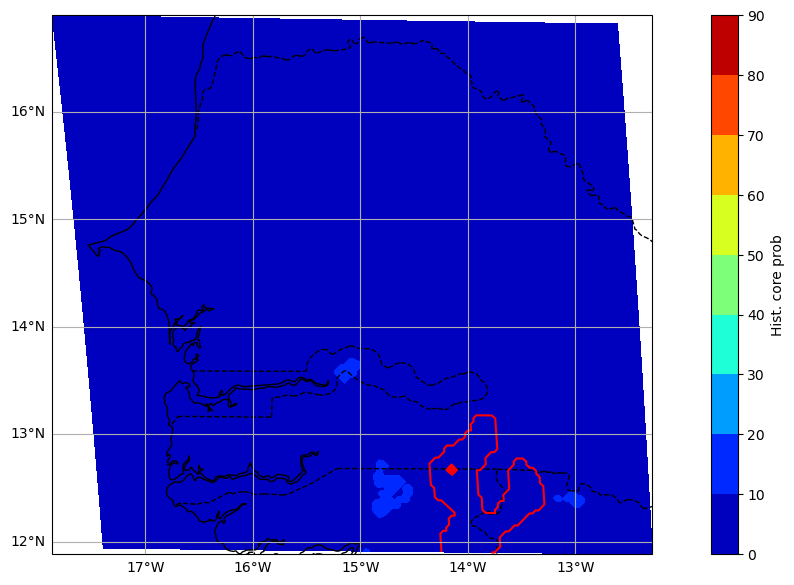

In [13]:
day = 24*19
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, hist_cores[day,:,:], lon, lat, levels=np.arange(0,100,10), cbar_label='Hist. core prob', cmap='jet')
# ax.contour(lon, lat, cores[day,:,:], levels=[-5,1,50], colors='r')
ax.contour(lon, lat, cores[day,:,:], colors='r')

#

In [14]:
# input data- cores_t_0: 
# starting at 
num_frames= 1  #8  # previous 2 hours of images to predict 1 hr later
t0= 0  #1   #*4 # # 15 min  later (4 frames at 15 min)
a= 45
b= 48
#cores_t_minus_xhr = cores[0:-2*t0, a:,b:]
#cores_t_0 = cores[t0:-t0, a:,b:]
#tir_t_minus_xhr = tir[0:-2*t0,a:,b:]
#tir_t_0 = tir[t0:-t0, a:,b:]
cores_t_0 = cores[0:-num_frames-t0, :-a,b:]
tir_t_0 = tir[0:-num_frames-t0, :-a,b:]
hist_cores_t_0 = hist_cores[0:-num_frames-t0, :-a,b:]
# normalize training data 
cores_t_0 = cores_t_0/np.max(cores_t_0)
hist_cores_t_0 = hist_cores_t_0/np.max(hist_cores_t_0)


#target data
cores_t_plus_xhr = cores[t0+num_frames:,:-a,b:]
ind = np.where(cores_t_plus_xhr>0)
cores_t_plus_xhr[ind] = 1
ind_not = np.where(cores_t_plus_xhr<=0)
cores_t_plus_xhr[ind_not] = 0
#print(np.unique(cores_t_plus_xhr))
#print(np.unique(cores_t_0))
#print(np.unique(hist_cores_t_0))


In [15]:
print(np.unique(cores_t_plus_xhr))
print(np.unique(cores_t_0))


[0. 1.]
[0.00000000e+00 2.68766630e-05 5.37533260e-05 ... 8.63439675e-01
 9.14800978e-01 1.00000000e+00]


In [16]:
#cores_t_plus_xhr = cores[t0+num_frames:, a:,b:]
#ind = np.where(cores_t_plus_xhr>0)
#print(np.unique(cores[:t0+num_frames,:-a,b:]))
#print(np.unique(cores[t0+num_frames:,:-a,b:]))
#print(np.unique(cores_t_plus_xhr))
#cores_t_plus_xhr.sum()
#print(cores_t_plus_xhr[ind])
#print(ind)
print(cores_t_0.shape)
print(hist_cores_t_0.shape)
print(cores_t_plus_xhr.shape)
a= 45
b= 48
num_frames= 1  #8  # previous 2 hours of images to predict 1 hr later
t0= 0

(8783, 128, 128)
(8783, 128, 128)
(8783, 128, 128)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


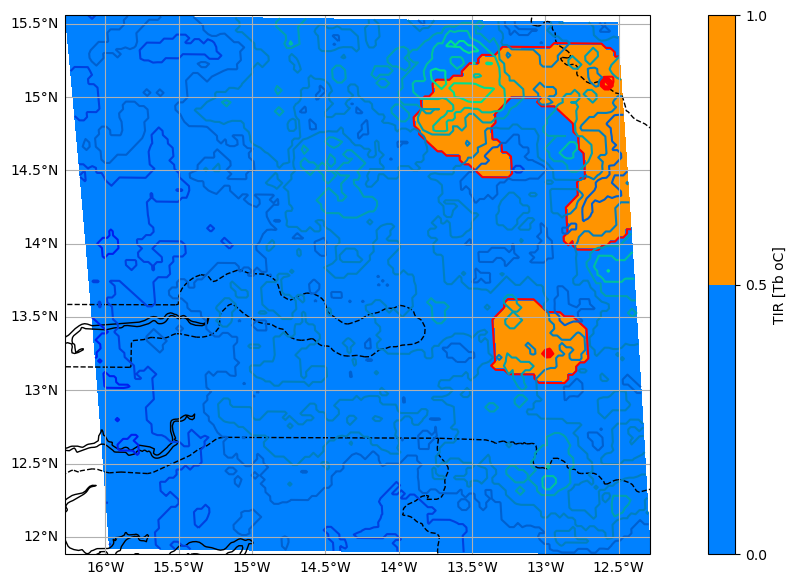

In [17]:
day = 96*19  #t0+num_frames+63  #96*19-36
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, cores_t_plus_xhr[day- (t0+num_frames),:,:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
ax.contour(lon[:-a,b:], lat[:-a,b:], cores_t_0[day,:,:], colors='r')
ax.contour(lon[:-a,b:], lat[:-a,b:], hist_cores_t_0[day,:,:], cmap='winter')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='TIR [Tb oC]', cmap='jet')
#draw_map(ax, cores[day,:-a,b:], lon[:-a,b:], lat[:-a,b:], cbar_label='TIR [Tb oC]', cmap='jet')

#

In [18]:
# save variables 
with open('pkl_files/WA_subdomain_cores_2hr_back_multichannel.pkl', 'wb') as file: 
          pickle.dump([cores_t_0,tir_t_0,hist_cores_t_0,cores_t_plus_xhr], file) 
        

In [19]:
# open a file, where you stored the pickled data
#file = open('pkl_files/WA_subdomain_cores_2hr_back_multichannel.pkl', 'rb')
#data = pickle.load(file)
#cores_t_0= data[0]
#tir_t_0= data[1]
#hist_cores_t_0= data[2]
#cores_t_plus_xhr= data[3]


In [20]:
# Define input shape
#num_frames= 24  # 6 hours
image_height= len(cores_t_plus_xhr[1,:,1]) #lat
image_width= len(cores_t_plus_xhr[1,1,:]) #lon
num_channels= 2 #  core at t0-       tir at t0-x, t0, , cores
#input_shape = (image_height, image_width, num_channels)
#input_shape = (num_frames, image_height, image_width, num_channels)
# Sample data (you should replace this with your own dataset)
#num_samples = len(cores_t_plus_xhr[0,0,:])
#sequence_length = 5



In [21]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, image_height,image_width, num_channels))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=16, #64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=8,#64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=2, kernel_size=(3, 3, 3), activation="relu", padding="same"
)(x)
x = layers.Dense(1, activation="sigmoid")(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)


In [22]:
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 128, 128,   0         
                             2)]                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 128, 128, 1  28864     
                             6)                                  
                                                                 
 batch_normalization (BatchN  (None, None, 128, 128, 1  64       
 ormalization)               6)                                  
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 128, 128, 8  6944      
                             )                                   
                                                                 
 batch_normalization_1 (Batc  (None, None, 128, 128, 8  32   

In [23]:
num_frames= 4   # 4  hours
batch_size= int(len(cores_t_0[:,0,0])/num_frames)  # days 720 - 96 one day
val_samples= 100
x_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, num_channels))
y_train= np.zeros((batch_size-val_samples,num_frames,image_height,image_width, 1))
x_val= np.zeros((val_samples,num_frames,image_height,image_width, num_channels))
y_val= np.zeros((val_samples,num_frames,image_height,image_width, 1))
                   
    
for i in range(0,batch_size-val_samples,1):  
    x_train[i,:,:,:,0]= cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    x_train[i,:,:,:,1]= hist_cores_t_0[i*num_frames:(i+1)*num_frames,:,:]
    y_train[i,:,:,:,0]= cores_t_plus_xhr[i*num_frames:(i+1)*num_frames,:,:]
    
    
val_ind= (i+1)*num_frames
    
for i in range(0,val_samples,1):  
    x_val[i,:,:,:,0]= cores_t_0[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]
    x_val[i,:,:,:,1]= hist_cores_t_0[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]
    y_val[i,:,:,:,0]= cores_t_plus_xhr[i*num_frames+val_ind:(i+1)*num_frames+val_ind,:,:]


In [24]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
#batch_size-val_samples
#batch_size

(2095, 4, 128, 128, 2)
(2095, 4, 128, 128, 1)
(100, 4, 128, 128, 2)
(100, 4, 128, 128, 1)


In [25]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 2 # 20
batch_size = 4 #50# batch_size#24

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

2023-12-18 16:37:36.484519: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1098383360 exceeds 10% of free system memory.
2023-12-18 16:37:36.998141: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 549191680 exceeds 10% of free system memory.


Epoch 1/2
524/524 [==============================] - 465s 878ms/step - loss: 0.0910 - val_loss: 0.0877 - lr: 0.0010
Epoch 2/2
524/524 [==============================] - 461s 879ms/step - loss: 0.0456 - val_loss: 0.0554 - lr: 0.0010


In [26]:
#example = x_val[np.random.choice(range(len(x_val)), size=1)[0]]
#print(example.shape)
#with open('WA_subdomain_trained_model_2hr_back_15min_forward.pkl', 'wb') as file: 
 #   pickle.dump(model, file) 
        

In [27]:
# Select a random example from the validation dataset.
# example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# for b in range(0,51,1):
batch_number = 25   #25 #b #50
frames = x_val[batch_number,0:2,:,:,:] # 
# original_frames = x_val[batch_number,2:,:,:,0] # 
original_frames = y_val[batch_number,1:3,:,:,0] # 
pred_frames = np.zeros(frames.shape[:-1])
pred_frames = np.expand_dims(pred_frames, axis=-1)


# Predict a new set of 4 frames.
for i in range(2):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    # Extend the set of prediction frames.
   # frames = np.concatenate((frames, predicted_frame), axis=0)
    pred_frames[i,:,:,:] =  predicted_frame


1/1 [==============================] - 0s 23ms/step


In [28]:
print(frames.shape)
print(pred_frames.shape)
print(original_frames.shape)

(2, 128, 128, 2)
(2, 128, 128, 1)
(2, 128, 128)


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


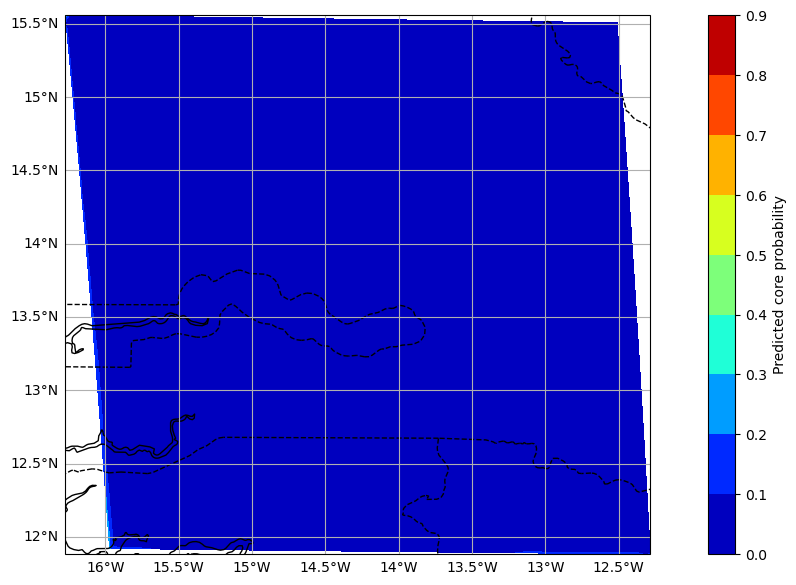

In [29]:
day = 0
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(pred_frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:], levels=np.arange(0,1,0.1), cbar_label='Predicted core probability', cmap='jet')
#draw_map(ax, np.squeeze(pred_frames[day,:,:,0]), lon[:-a,b:], lat[:-a,b:], levels=[0,0.5,1], cbar_label='Predicted core probability', cmap='jet')

#

/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


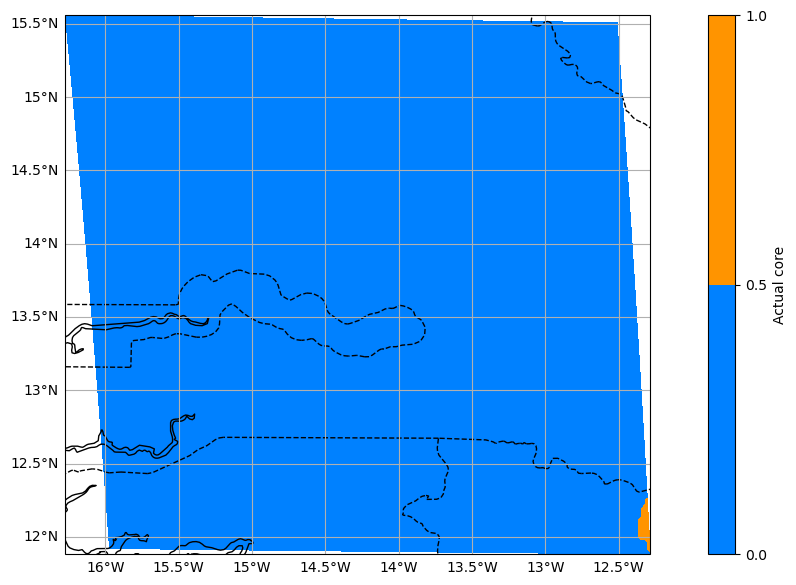

In [30]:
#day = 23 #96*19-36
f=plt.figure(figsize=(15,7)) 
ax = f.add_subplot(111, projection=ccrs.PlateCarree()) 
draw_map(ax, np.squeeze(original_frames[day,:,:]), lon[:-a,b:], lat[:-a,b:],levels=[0,.5,1], cbar_label='Actual core', cmap='jet')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

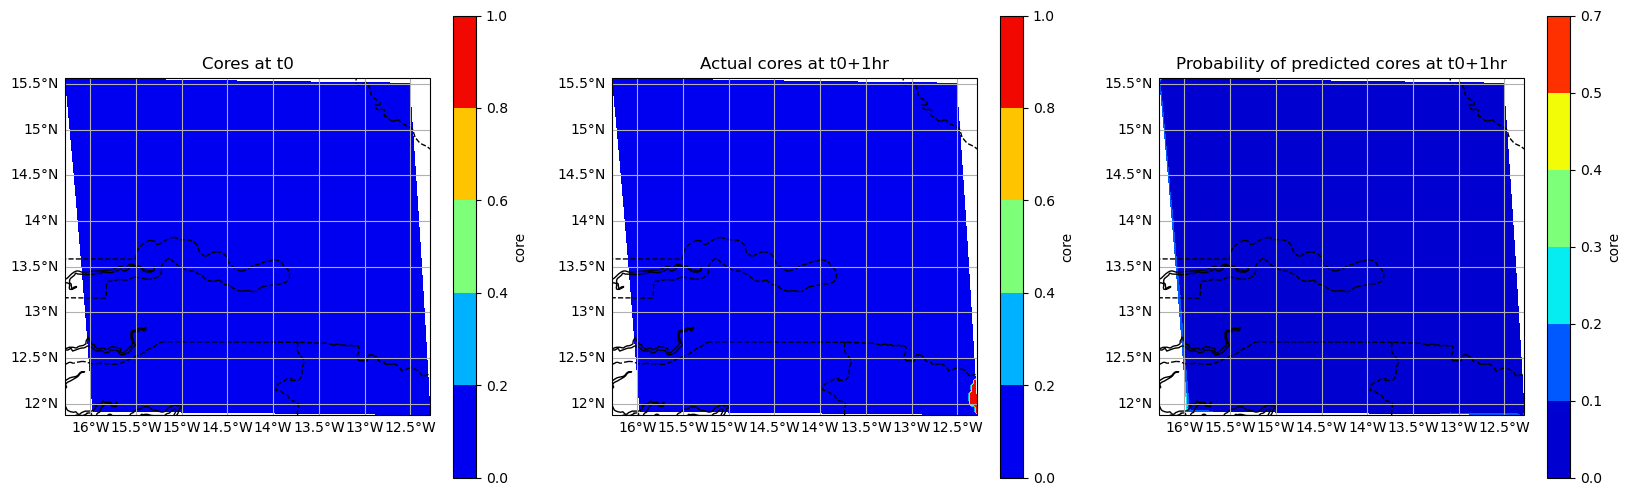

In [31]:
day = 3-2
data = np.zeros((3,image_height,image_width))
#data[0] = np.squeeze(frames[day-4*t0,:,:,0])
data[0] = np.squeeze(frames[day,:,:,0])
data[1] = np.squeeze(original_frames[0,:,:])
data[2] = np.squeeze(pred_frames[day-1,:,:,0])
titles = ['Cores at t0', 'Actual cores at t0+1hr', 'Probability of predicted cores at t0+1hr']
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.2, 0.4, 0.6, 0.8,1],[0, 0.1, 0.2, 0.3, 0.4,0.5,0.7]]#[0, 0.1, 0.2, 0.3,0.4]]

fig, axes = plt.subplots(1, 3, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

i=0
for ax in axes:
    m= ax.contourf(lon[:-a,b:], lat[:-a,b:], data[i], transform=ccrs.PlateCarree(), levels=levels_custom[i],cmap='jet')  # this is the actual plot
# ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(titles[i])
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')
    i=i+1
 
#plt.show()

In [32]:
def plot_maps(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    #cbar = plt.colorbar(m)  # adds colorbar
    #cbar.set_label('core')


In [33]:
def plot_maps_colorbar(ax, lon, lat, data, title,levels_custom):
    m=ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), levels=levels_custom,cmap='jet')  # this is the actual plot
    ax.coastlines()   ## adds coastlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    ax.set_title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(m)  # adds colorbar
    cbar.set_label('core')


/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/users/global/jawahm/miniforge3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility

Predicting core at 1hr


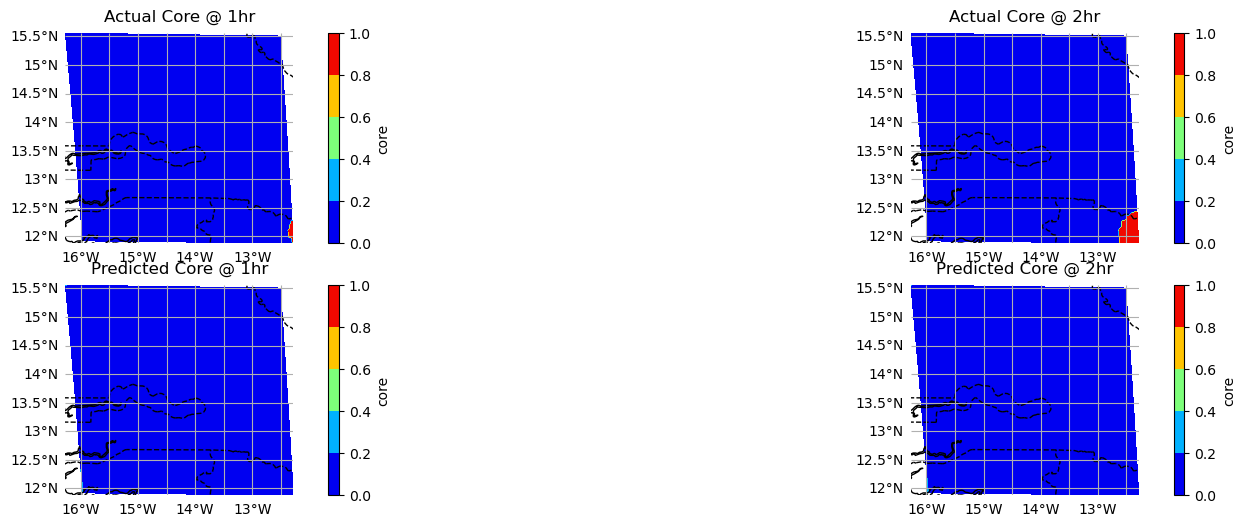

In [34]:
day = 4-2
data = np.zeros((day,image_height,image_width))
for x in range(0,2,1):
    data[x] = np.squeeze(pred_frames[x,:,:,0])
        
levels_custom=[[0, 0.2, 0.4, 0.6, 0.8,1],np.arange(0,1.1,0.2)]  #[0, 0.1, 0.2, 0.3,0.4]]
#levels_custom=[[0, 0.5 ,1],[0, 0.5 ,1]]  #[0, 0.1, 0.2, 0.3,0.4]]
    
fig, axes = plt.subplots(2, 2, figsize=(20, 6),
                         subplot_kw={'projection':ccrs.PlateCarree()})

for idx, ax in enumerate(axes[0]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], np.squeeze(original_frames[idx,:,:]),  title=None ,levels_custom= levels_custom[0])
    ax.set_title(f"Actual Core @ {idx + 1}hr")
    ax.axis("off")

for idx, ax in enumerate(axes[1]):
    plot_maps_colorbar(ax, lon[:-a,b:], lat[:-a,b:], data[idx,:,:],  title=None ,levels_custom= levels_custom[1])
    ax.set_title(f"Predicted Core @ {idx + 1}hr")
    ax.axis("off")

# Print information and display the figure.
print('Predicting core at 1hr')
plt.show()